# Sustainable Heating & Cooling project 

Maywand Akhtari 
Arthur Dattin

#### Data and Package importation: 

In [2]:
from pylab import *
from Compressor_model import recip_comp_SP
from scipy.integrate import odeint
from scipy.optimize import  minimize,NonlinearConstraint #optimization
import CoolProp.CoolProp as CP
import plotDiag_Th_Ts as Diag
import matplotlib.pyplot as plt
import numpy as np
from math import pi, log
import Fluid_CP as FCP #calculation of  thermodynamic states
import pandas as pd
import gurobipy as gp
from gurobipy import GRB
from numpy.polynomial import Polynomial

In [ ]:
sim_duration = 12 * 3600      # [s] total simulation time (12 h)

# === Pasta cooking parameters ===
m_pasta_batch   = 2.0         # [kg] pasta per batch
m_pasta_basket  = 0.5         # [kg] pasta per basket
n_baskets       = 4.0         # number of pasta baskets
t_env           = 20.0        # [°C] outside temperature
t_p_0           = 7.0         # [°C] initial pasta temperature
t_p_tgt         = 85.0        # [°C] cooking temperature 
t_w_init        = 20.0        # [°C] ambient start temperature 
t_w_min         = 85.0        # [°C] lower control bound 
t_w_max         = 93.0        # [°C] upper control bound 
t_cook          = 7 * 60      # [s] cooking time per batch 
t_break         = 5 * 60      # [s] break between batches 

# === Thermal resistances ===
r_env_water   = 30.0          #[K/Kw] environment  water 
r_water_pasta = 15.0          #[K/Kw] water  pasta 

# === Specific heats ===
cp_water = 4.18            # [kJ/kg/K] water 
cp_pasta = 3.5              # [kJ/kg/K] pasta 

# === Cooker Dimensions ===
W_ext = 0.27 #[m]
L_ext = 0.47 #[m]
W_in = 0.10 #[m]
L_in = 0.20 #[m]
H_ext = 0.20 #[m]
H_in = 0.15 #[m]
wall_thick = 0.02 #[m]

#ACTUALLY USED
#all dimensions in [mm]
pipe_diameter = 6.35
length_available = 466
height_available = 48
width_available = 266

# === Condenser dimensions ===
d_o=0.0635 # outer tube diameter [m]
d_i =0.0473 # inner tube diameter [m]
d_w = 0.0008 # tube wall thickness [m]
mw = 24.54 # =26.6*46.6*19.8*(10**-6)*1000  mass of water in the condenser [kg]
delta_sc = 0 # We consider no supercooling in the condenser

# Electricity price 
Co2 = 0.017 #[kg CO2-eq/kWh]
price =  0.07  # [CHF /kW]


## Task 1 : Pasta Cooking System with Electric Heating


## System Parameters and Variables
### Simulation Parameters:

Simulation duration: $t_{sim} = 12 \times 3600$ s (12 hours)
Single cycle analysis: $t_{cycle} = 12 \times 60$ s (cooking + pause)
### Pasta Cooking Parameters:

Pasta batch mass: $m_{pasta} = 2.0$ kg per batch
Cooking time: $t_{cook} = 7 \times 60$ s (420 seconds)
Break time: $t_{break} = 5 \times 60$ s (300 seconds)
Initial pasta temperature: $T_{p,0} = 7°C$
Target pasta temperature: $T_{p,target} = 85°C$
### Water System Parameters:

Water mass: $m_w = 24.54$ kg
Initial water temperature: $T_{w,init} = 20°C$
Operating temperature range: $85°C \leq T_w \leq 93°C$
### Thermal Properties:

Water specific heat: $c_{p,w} = 4.18$ kJ/(kg·K)
Pasta specific heat: $c_{p,pasta} = 3.5$ kJ/(kg·K)
Environment-water thermal resistance: $R_{env-water} = 30.0$ K/kW
Water-pasta thermal resistance: $R_{water-pasta} = 15.0$ K/kW

## Temperature Dynamics Model
The thermal behavior of the pasta cooking system is governed by energy balance equations:

Water Temperature Dynamics: $$\frac{dT_w}{dt} = \frac{1}{m_w \cdot c_{p,w}} \left[ \dot{Q_{wp}} - \frac{T_w - T_p}{R{water-pasta}} - \frac{T_w - T_{env}}{R_{env-water}} \right]$$

Pasta Temperature Dynamics: $$\frac{dT_p}{dt} = \frac{1}{R_{water-pasta} \cdot m_{pasta} \cdot c_{p,pasta}} (T_w - T_p)$$

Heat Transfer Rates: $$\dot{Q}{pasta} = \frac{T_w - T_p}{R{water-pasta}}$$

$$\dot{Q}{env} = \frac{T_w - T{env}}{R_{env-water}}$$

## Control Strategy Implementation
### Simple On/Off Controller
The hysteresis controller is implemented with the following logic:

$$\dot{Q}_{WP} = \begin{cases} 
\dot{Q}_{HP} & \text{if } T_w \leq T_{WP,on} + 1°C \text{ or } (WP = 1 \text{ and } T_w \leq T_{WP,off}) \\
0 & \text{if } T_w > T_{WP,off} \text{ or } (WP = 0 \text{ and } T_w > T_{WP,on} + 1°C)
\end{cases}$$

Where:

$T_{WP,on} = 85°C$ (turn-on threshold)
$T_{WP,off} = 93°C$ (turn-off threshold)
1°C buffer prevents oscillations around the threshold
### Optimized Control Strategy (Gurobi Solver)
The optimization problem minimizes total energy consumption:

Objective Function: $$\text{minimize: } \sum_{k=0}^{horizon-1} u[k]$$

Subject to Constraints:

Temperature Bounds: $$T_{w,min} \leq T_w[k] \leq T_{w,max} \quad \forall k$$ $$85°C \leq T_w[k] \leq 93°C$$

Pasta Target Constraint: $$T_p[t_{cook}/dt] \geq T_{p,target} = 85°C$$

System Dynamics: $$T_w[k+1] = T_w[k] + dt \cdot \frac{\dot{Q}{in}[k] - \dot{Q}{loss}[k] - \dot{Q}{pasta}[k]}{m_w \cdot c{p,w}}$$

$$T_p[k+1] = T_p[k] + dt \cdot \frac{\dot{Q}{pasta}[k]}{m{pasta} \cdot c_{p,pasta}}$$

Boundary Conditions: $$T_w[0] = T_{w,init}, \quad T_p[0] = T_{p,0}$$ $$T_w[horizon] = T_{w,init} \quad \text{(cyclic constraint)}$$

## Power Requirement Analysis
### Minimum Heating Power Determination
Constraints:

Water temperature must NEVER drop below 85°C
Pasta must reach 85°C within 7 minutes
Initial water temperature starts at 86°C (1°C buffer above minimum)
Success Criteria: $$\text{Success} = \begin{cases} \text{True} & \text{if } \min(T_w) \geq 85°C \text{ and } T_p(420s) \geq 85°C \\ 
\text{False} & \text{otherwise} \end{cases}$$

Conventional Heating Analysis
For initial heating from ambient temperature:

Energy Balance: $$m_w \cdot c_w \cdot \frac{dT_w}{dt} = P_{max} - \frac{T_w - T_{inf}}{R_{env}}$$

Solution: $$T_w(t) = T_{inf} + (T_{w,init} - T_{inf}) \cdot e^{-t/\tau} + P_{max} \cdot R_{env} \cdot (1 - e^{-t/\tau})$$

Where $\tau = m_w \cdot c_w \cdot R_{env}$ is the thermal time constant.

### Energy Consumption Analysis
Total Energy Consumption (12-hour operation): $$E_{total} = E_{initial_heating} + E_{operational} \times N_{cycles}$$

Where:

$E_{initial_heating}$: Energy to heat from 20°C to 86°C
$E_{operational}$: Energy per 12-minute cycle
$N_{cycles} = \frac{12 \times 60 - t_{heating}}{12}$: Number of operational cycles

In [5]:
def calc_WP(T, T_WP_on, T_WP_off, op_times, QHP):
    """
    Heat pump on/off controller.
    
    Args:
        T: current water temperature [°C]
        T_WP_on: turn-on temperature threshold [°C] (85°C)
        T_WP_off: turn-off temperature threshold [°C] (93°C)
        op_times: list to store operating durations
        QHP:  power output when on [kW]
    
    Returns:
        Q_WP: current power output [kW]
    """
    global WP, time  # WP=pump state (0/1), time=operation counter
    
    # === CASE 1: Pump OFF and temperature ABOVE turn-on threshold ===
    if WP == 0 and T > T_WP_on:
        Q_WP = 0.               # Keep pump OFF
        WP = 0                  # Maintain OFF state
        
    # === CASE 2: Pump OFF and temperature AT/BELOW turn-on threshold ===
    if WP == 0 and T <= T_WP_on+1: # Allow small tolerance for turn-on of 1°C
        Q_WP = QHP              # Switch pump ON
        WP = 1                  # Set state to ON
        time += 1               # Start counting operation time
        
    # === CASE 3: Pump ON and temperature BELOW turn-off threshold ===
    if WP == 1 and T <= T_WP_off:
        Q_WP = QHP              # Keep pump ON
        time += 1               # Continue counting operation time
        
    # === CASE 4: Pump ON and temperature ABOVE turn-off threshold ===
    if WP == 1 and T > T_WP_off:
        Q_WP = 0.               # Switch pump OFF
        WP = 0                  # Set state to OFF
        op_times.append(time)   # Record this operation cycle duration
        time = 0                # Reset operation counter
        
    return Q_WP

In [6]:
def temp_water_pasta(T, t, Q_WP):
    """
    Calculates temperature derivatives for the pasta cooking system.
    
    Args:
        T: tuple (Tw, Tp) - current water and pasta temperatures [°C]
        t: time (unused but required by odeint)
        Q_WP: heat pump power [kW]
    
    Returns:
        [dTw/dt, dTp/dt] - temperature derivatives [°C/s]
    """
    Tw, Tp = T  # Extract current temperatures
    
    # Water temperature derivative: dTw/dt
    # Energy balance: m*cp*dT/dt = Q_in - Q_losses
    return [
        # dTw/dt = (Q_pump - Q_losses) / (mass * specific_heat)
        (-1/(mw*cp_water)) * (
            (1/r_water_pasta)*(Tw - Tp) +      # Heat transfer to pasta
            (1/r_env_water)*(Tw - t_env)       # Heat loss to environment
        ) + (1/(mw*cp_water))*Q_WP,             # Heat pump input
        
        # dTp/dt = Q_from_water / (mass * specific_heat)
        (1/(r_water_pasta*m_pasta_batch*cp_pasta))*(Tw - Tp)  # Heat from water
    ]

In [7]:
def T_water_pasta(T_WP_on,T_WP_off,n,op_times,Qhp):
    QHP = Qhp #kW heat pump power
    #initial storage temperature
    T0 = (t_w_min,t_p_0) #fully charged
    # time points
    t = linspace(0,n,n)
    # store storage temperature
    T=np.zeros((n,2))
    # save initial storage temperature
    T[0,0] = t_w_min
    T[0,1] = t_p_0
    
    # heat pump
    Q_WPs=zeros(n) #store power of heat pump
    Q_WPs[0]=0 #kW power of heat pump at t=0 is 0 kW

    # solve differential equation for the storage temperature
    for i in range(1,n):
        # span for next time step
        tspan = [t[i-1],t[i]]
        # solve for next step
        z = odeint(temp_water_pasta,T0,tspan,args=(Q_WPs[i-1],))
        #heat pump power for netxt time step
        Q_WPs[i]=calc_WP(z[1,0],T_WP_on,T_WP_off,op_times,QHP)
        # store storage temperature
        T[i,0] = z[1,0]
        T[i,1] = z[1,1]
        # next initial condition
        T0 = (z[1,0],z[1,1])
        
    return t,Q_WPs,T

In [8]:
def find_minimum_heating_power(
    power_min=4.0, 
    power_max=8.0, 
    power_step=0.1,
    simulation_duration=10*60,  # [s] 
    T_WP_on=85.0, 
    T_WP_off=93.0,  # [°C] control thresholds
    target_pasta_temp=85.0,  # [°C] target pasta temperature
    target_time_seconds=420  # [s] time limit to reach target (7 minutes)
    ):
    """
    Find the minimum heat pump power required for pasta to reach target temperature within specified time.
    CONSTRAINT: Water temperature must ALWAYS stay above 85°C during operation.
    starting a 86 deg 
    
    Args:
        power_min: minimum power to test [kW]
        power_max: maximum power to test [kW] 
        power_step: power increment [kW]
        simulation_duration: total simulation time [s]
        T_WP_on: heat pump turn-on temperature [°C]
        T_WP_off: heat pump turn-off temperature [°C]
        target_pasta_temp: target pasta temperature [°C]
        target_time_seconds: maximum time allowed to reach target [s]
    
    Returns:
        float: minimum power needed [kW], or None if target not achievable
    """
    
    # Calculate power range and initialize results matrix
    power_range = np.arange(power_min, power_max + power_step, power_step)
    n_powers = len(power_range)
    results_matrix = np.zeros((n_powers, 5))  # [power, pasta_temp_at_target_time, time_to_reach_target, success, min_water_temp]
    
    print(f"Testing {n_powers} power levels from {power_min:.1f} to {power_max:.1f} kW")
    print(f"Target: Pasta reaches {target_pasta_temp}°C within {target_time_seconds} seconds")
    print(f"CONSTRAINT: Water temperature must stay above {T_WP_on}°C at all times")
    
    for i, power_kw in enumerate(power_range):
        # Reset global variables for heat pump controller
        global time, WP, op_times1
        time = 0  # HP operation timer
        WP = 1    # HP state (0=off, 1=on)
        op_times1 = []  # List to store operating durations
        
        # Store current power being tested
        results_matrix[i, 0] = power_kw
        
        # Run temperature simulation with INITIAL TEMPERATURE SET TO OPERATING RANGE
        # IMPORTANT: Start at minimum operating temperature (85°C) instead of t_w_min
        initial_water_temp = T_WP_on+1  # Start at 86°C (operating temperature)
        
        # Temporarily modify global t_w_min for this simulation
        original_t_w_min = globals().get('t_w_min', 85.0)
        globals()['t_w_min'] = initial_water_temp  # Set to 86°C for proper initialization
        
        try:
            t_sim, Q_WPs_sim, T_sim = T_water_pasta(T_WP_on, T_WP_off, simulation_duration, op_times1, power_kw)
            
            # Check water temperature constraint violation
            water_temps = T_sim[:, 0]  # Water temperature column
            min_water_temp = np.min(water_temps)
            results_matrix[i, 4] = min_water_temp
            
            # CRITICAL CONSTRAINT CHECK: Water temperature must NEVER drop below 85°C
            water_constraint_violated = min_water_temp < T_WP_on
            
            if water_constraint_violated:
                results_matrix[i, 3] = 0  # Mark as failed
                results_matrix[i, 2] = np.inf  # Infinite time (failed)
                
                # Record pasta temperature at target time anyway for analysis
                target_time_index = min(int(target_time_seconds), len(T_sim) - 1)
                results_matrix[i, 1] = T_sim[target_time_index, 1]
                continue
            
            # Check when pasta reaches target temperature
            pasta_temps = T_sim[:, 1]  # Pasta temperature column
            time_to_target = None
            target_reached = False

            # Find the first time pasta reaches target temperature
            for j, pasta_temp in enumerate(pasta_temps):
                if pasta_temp >= target_pasta_temp:
                    time_to_target = t_sim[j]  # Time when target was reached
                    target_reached = True
                    break
            
            # Check if target was reached within time limit AND water constraint satisfied
            if target_reached and time_to_target <= target_time_seconds and not water_constraint_violated:
                success = 1
                results_matrix[i, 2] = time_to_target
                print(f"Power {power_kw:.1f}kW: SUCCESS - Pasta target reached in {time_to_target:.0f}s, min water temp: {min_water_temp:.1f}°C")
            else:
                success = 0
                results_matrix[i, 2] = np.inf if not target_reached else time_to_target

            # Record pasta temperature at the target time index
            target_time_index = min(int(target_time_seconds), len(T_sim) - 1)
            results_matrix[i, 1] = pasta_temps[target_time_index]
            results_matrix[i, 3] = success
            
        except Exception as e:
            print(f"Power {power_kw:.1f}kW: ERROR during simulation - {e}")
            results_matrix[i, 3] = 0  # Mark as failed
            results_matrix[i, 2] = np.inf
            results_matrix[i, 1] = 0
            results_matrix[i, 4] = 0
        
        finally:
            # Restore original t_w_min
            globals()['t_w_min'] = original_t_w_min
            
            # Finalize operating times if HP is still running
            if time != 0:
                op_times1.append(time)
    
    # Find minimum power that achieves target within time limit AND satisfies water constraint
    successful_tests = results_matrix[:, 3] == 1  # Success column
    
    if np.any(successful_tests):
        # Get the first successful test (minimum power)
        success_idx = np.argmax(successful_tests)  # First True index
        required_power = results_matrix[success_idx, 0]
        time_taken = results_matrix[success_idx, 2]
        min_water_temp = results_matrix[success_idx, 4]
        
        print(f"\n SUCCESS: Required heating power: {required_power:.1f}kW")
        print(f"   Pasta reaches {target_pasta_temp}°C in {time_taken:.0f} seconds")
        print(f"   Water temperature maintained above {T_WP_on}°C (minimum: {min_water_temp:.1f}°C)")
        print(f"   Safety margin: {target_time_seconds - time_taken:.0f} seconds")
        
        # Show constraint compliance statistics
        all_successful = results_matrix[successful_tests]
        print(f"   {len(all_successful)} power levels meet all constraints")
        
        return required_power
    else:
        print("Failure")
        return None


P_max = find_minimum_heating_power(
    power_min=0.0, 
    power_max=5.0,              
    power_step=0.1,
    simulation_duration=10*60,  # 10 minutes simulation
    T_WP_on=85.0,              # CONSTRAINT: Water must stay above 85°C
    T_WP_off=93.0,             # Maximum water temperature
    target_pasta_temp=85.0,    # Target pasta temperature
    target_time_seconds=420    # Must reach target within 7 minutes (420 seconds)
)
P_max = P_max*1000  # Convert to W for consistency
if P_max is not None:
    print(f"\n FINAL RESULT: Minimum power required = {P_max:.1f} W")


Testing 51 power levels from 0.0 to 5.0 kW
Target: Pasta reaches 85.0°C within 420 seconds
CONSTRAINT: Water temperature must stay above 85.0°C at all times
Power 4.7kW: SUCCESS - Pasta target reached in 360s, min water temp: 85.1°C
Power 4.8kW: SUCCESS - Pasta target reached in 355s, min water temp: 85.1°C
Power 4.9kW: SUCCESS - Pasta target reached in 350s, min water temp: 85.2°C
Power 5.0kW: SUCCESS - Pasta target reached in 345s, min water temp: 85.3°C

 SUCCESS: Required heating power: 4.7kW
   Pasta reaches 85.0°C in 360 seconds
   Water temperature maintained above 85.0°C (minimum: 85.1°C)
   Safety margin: 60 seconds
   4 power levels meet all constraints

 FINAL RESULT: Minimum power required = 4700.0 W


Heating water from 20.0°C to 86°C using 4700W

Heating Results:
Time required: 32.4 minutes (1943 seconds)
Energy consumed: 2.537 kWh
Final temperature: 86.02°C
Average power during heating: 4.7 kW


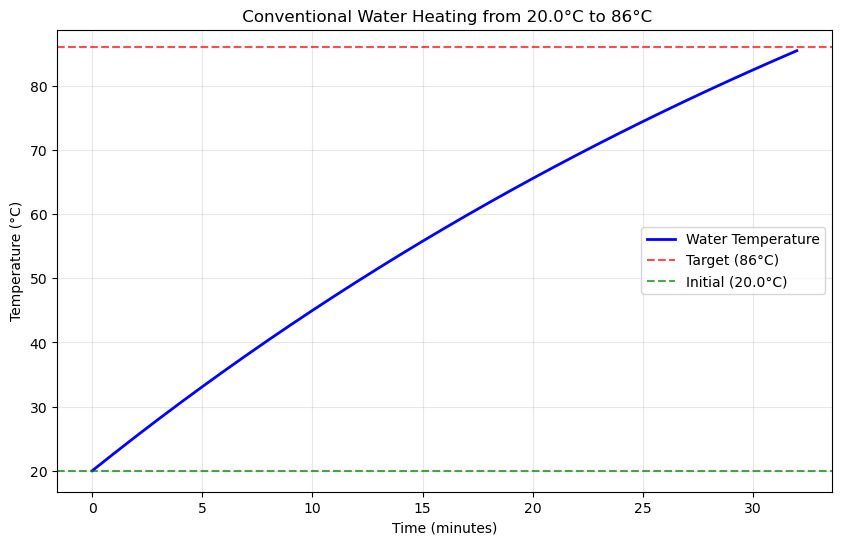

In [9]:
def calculate_heating_time_energy(
    T_initial=20.0,        # [°C] initial water temperature
    T_final=86.35,         # [°C] target water temperature  
    P_max=4700,            # [W] maximum heating power
    mw=24.54,              # [kg] water mass
    c_w=4180.0,            # [J/(kg·K)] water heat capacity
    R_env=30e-3,           # [K/W] environmental resistance
    T_inf=20.0,            # [°C] ambient temperature
    dt=1.0                 # [s] time step
):
    """
    Calculate time and energy needed to heat water from initial to final temperature.
    
    Args:
        T_initial: starting water temperature [°C]
        T_final: target water temperature [°C]
        P_max: maximum heating power [W]
        mw: water mass [kg]
        c_w: water heat capacity [J/(kg·K)]
        R_env: environmental thermal resistance [K/W]
        T_inf: ambient temperature [°C]
        dt: time step [s]
    
    Returns:
        dict: {'time_seconds': float, 'time_minutes': float, 'energy_kwh': float, 'temperatures': array}
    """
    
    # Initialize variables
    T_w = T_initial
    time_elapsed = 0
    total_energy = 0  # [J]
    temperatures = [T_w]
    times = [0]
    
    print(f"Heating water from {T_initial}°C to {T_final}°C using {P_max}W")
    
    # Heat until target temperature is reached
    while T_w < T_final:
        # Heat loss to environment
        Q_loss = (T_w - T_inf) / R_env  # [W]
        
        # Net heating power
        Q_net = P_max - Q_loss  # [W]
        
        # Temperature change rate
        dT_dt = Q_net / (mw * c_w)  # [°C/s]
        
        # Update temperature
        T_w += dT_dt * dt
        
        # Update time and energy
        time_elapsed += dt
        total_energy += P_max * dt  # [J]
        
        # Store for plotting (every 60 seconds to avoid huge arrays)
        if int(time_elapsed) % 60 == 0:
            temperatures.append(T_w)
            times.append(time_elapsed)
        
        # Safety check to avoid infinite loop
        if time_elapsed > 10000:  # 10000 seconds = ~2.8 hours
            print("Warning: Heating taking too long, check parameters")
            break
    
    # Convert energy to kWh
    energy_kwh = total_energy / (1000 * 3600)  # [kWh]
    time_minutes = time_elapsed / 60  # [minutes]
    
    # Print results
    print(f"\nHeating Results:")
    print(f"Time required: {time_minutes:.1f} minutes ({time_elapsed:.0f} seconds)")
    print(f"Energy consumed: {energy_kwh:.3f} kWh")
    print(f"Final temperature: {T_w:.2f}°C")
    print(f"Average power during heating: {P_max/1000:.1f} kW")
    
    # Optional: Plot temperature vs time
    import matplotlib.pyplot as plt
    plt.figure(figsize=(10, 6))
    plt.plot(np.array(times)/60, temperatures, 'b-', linewidth=2, label='Water Temperature')
    plt.axhline(y=T_final, color='r', linestyle='--', alpha=0.7, label=f'Target ({T_final}°C)')
    plt.axhline(y=T_initial, color='g', linestyle='--', alpha=0.7, label=f'Initial ({T_initial}°C)')
    plt.xlabel('Time (minutes)')
    plt.ylabel('Temperature (°C)')
    plt.title(f' Conventional Water Heating from {T_initial}°C to {T_final}°C')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()
    
    return {
        'time_seconds': time_elapsed,
        'time_minutes': time_minutes,
        'energy_kwh': energy_kwh,
        'final_temperature': T_w,
        'temperatures': np.array(temperatures),
        'times': np.array(times)
    }

heating_results_conv = calculate_heating_time_energy(T_initial=20.0,T_final=86, P_max=4700)


Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2648242


Academic license 2648242 - for non-commercial use only - registered to ad___@ethz.ch
Heating on = 451.0 times, total duration = 12.0 minutes


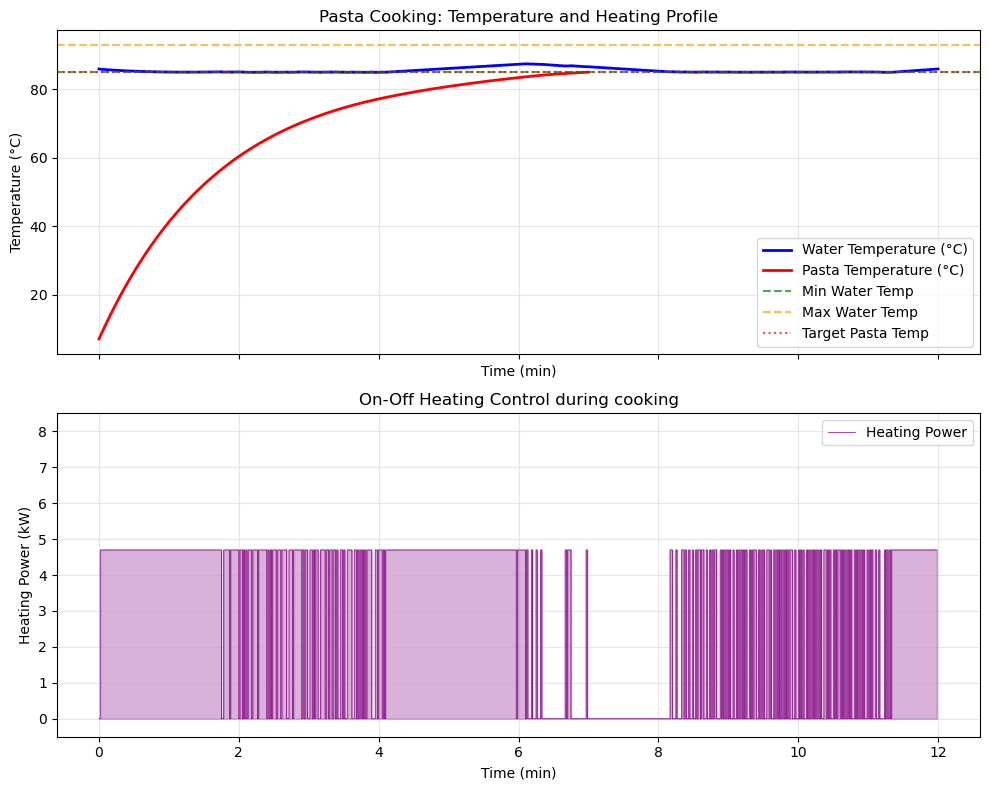


Heating Statistics:
Total cooking time: 12.0 minutes
Heater ON during: 7.5 minutes (62.6%)
Total energy consumed: 0.035 kWh
Final pasta temperature: 85.0°C
Final water temperature: 86.0°C


In [10]:
def optimized_on_off_control_cooking(
    m_w=24.54, c_w=4180.0,  # water mass [kg], heat capacity [J/(kg·K)]
    m_p=2.0, c_p=3500.0,   # pasta mass [kg], heat capacity [J/(kg·K)]
    R_env=30e-3,           # environmental resistance [K/W]
    R_wp=15e-3,            # water pasta resistance [K/W]
    T_inf=20.0,            # ambient [°C]
    Tw0=86, Tp0=7.0,      # initial temperatures [°C]
    T_w_min=85.0, T_w_max=93.0, T_p_target=85.0,
    P_max=4700,          # max heating power [W]
    duration=12*60.0, dt=1.0,  # total time [s], timestep [s]
    t_cook=7*60.0, t_break=5*60.0  # cooking time [s], break time [s]
    ):
    horizon = int(duration / dt)
    
    # Create model
    m = gp.Model("pasta_onoff")
    m.setParam('OutputFlag', 0)
    m.setParam('TimeLimit', 300)     # 5-minute time limit
    m.setParam('MIPGap', 0.01)       # 1% optimality gap
    m.setParam('Threads', 4)  

    # Variables
    u = m.addVars(horizon, vtype=GRB.BINARY, name="u")  
    Tw = m.addVars(horizon+1, lb=-GRB.INFINITY, name="Tw")
    Tp = m.addVars(horizon+1, lb=-GRB.INFINITY, name="Tp")

    # Initial conditions
    m.addConstr(Tw[0] == Tw0, name="init_Tw")
    m.addConstr(Tp[0] == Tp0, name="init_Tp")

    # Dynamics
    for k in range(horizon):
        if k < int(t_cook / dt):
            heat_in = P_max * u[k]
            Q_loss = (Tw[k] - T_inf) / R_env
            Q_pasta = (Tw[k] - Tp[k]) / R_wp
            dTw = (heat_in - Q_loss - Q_pasta) / (m_w * c_w)
            m.addConstr(Tw[k+1] == Tw[k] + dt * dTw, name=f"dyn_w_{k}")

            dTp = Q_pasta / (m_p * c_p)
            m.addConstr(Tp[k+1] == Tp[k] + dt * dTp, name=f"dyn_p_{k}")
        else:
            heat_in = P_max * u[k]
            Q_loss = (Tw[k] - T_inf) / R_env
            Q_pasta = 0
            dTw = (heat_in - Q_loss - Q_pasta) / (m_w * c_w)
            m.addConstr(Tw[k+1] == Tw[k] + dt * dTw, name=f"dyn_w_{k}")
            m.addConstr(Tp[k+1] == Tp[k] , name=f"dyn_p_{k}")

        m.addConstr(Tw[k] >= T_w_min, name=f"min_Tw_{k}")
        m.addConstr(Tw[k] <= T_w_max, name=f"max_Tw_{k}")

    m.addConstr(Tp[int(t_cook / dt)] >= T_p_target, name="target_Tp")
    m.addConstr(Tw[horizon] == Tw0, name="final_Tw")

    m.setObjective(gp.quicksum(u[k] for k in range(horizon)), GRB.MINIMIZE)
    m.optimize()

    u_opt = np.array([u[k].X for k in range(horizon)])
    Tw_opt = np.array([Tw[k].X for k in range(horizon+1)])
    Tp_opt = np.array([Tp[k].X for k in range(horizon+1)])

    # Set pasta temperature to NaN after cooking period for plotting
    Tp_plot = Tp_opt.copy()
    cook_end_idx = int(t_cook / dt)
    Tp_plot[cook_end_idx+1:] = np.nan  
    return {
        'u': u_opt,
        'Tw': Tw_opt,
        'Tp': Tp_plot,
        'dt': dt,
        'duration': duration}

# Run optimization
result = optimized_on_off_control_cooking()
Tw = result['Tw']
Tp = result['Tp']
u_heating = result['u']  # heating on/off profile
dt = result['dt']
duration = result['duration']
t = np.arange(0, duration + dt, dt) / 60  # time in minutes
t_heating = np.arange(0, duration, dt) / 60  # time for heating profile (one less point)
print(f"Heating on = {np.sum(result['u'])} times, total duration = {duration/60:.1f} minutes")

# Calculate actual heating power
heating_power = u_heating * P_max/1000   # Convert to kW for better scale

# Plot temperatures and heating profile
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

# Temperature plot
ax1.plot(t, Tw, 'b-', linewidth=2, label='Water Temperature (°C)')
ax1.plot(t, Tp, 'r-', linewidth=2, label='Pasta Temperature (°C)')
ax1.axhline(y=85, color='g', linestyle='--', alpha=0.7, label='Min Water Temp')
ax1.axhline(y=93, color='orange', linestyle='--', alpha=0.7, label='Max Water Temp')
ax1.axhline(y=85, color='r', linestyle=':', alpha=0.7, label='Target Pasta Temp')
ax1.set_ylabel('Temperature (°C)')
ax1.set_xlabel('Time (min)')
ax1.set_title('Pasta Cooking: Temperature and Heating Profile')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Heating power plot
ax2.step(t_heating, heating_power, 'purple', linewidth=0.5, where='post', label='Heating Power')
ax2.fill_between(t_heating, 0, heating_power, step='post', alpha=0.3, color='purple')
ax2.set_xlabel('Time (min)')
ax2.set_ylabel('Heating Power (kW)')
ax2.set_title('On-Off Heating Control during cooking')
ax2.legend()
ax2.grid(True, alpha=0.3)
ax2.set_ylim(-0.5, 8.5)


plt.tight_layout()
plt.show()

# Print some statistics
total_energy_on_off_opt = np.sum(heating_power) * dt / 60 / 1000  # kWh
on_time = np.sum(u_heating) * dt / 60  # minutes
efficiency = (on_time / (duration/60)) * 100  # percentage

print(f"\nHeating Statistics:")
print(f"Total cooking time: {duration/60:.1f} minutes")
print(f"Heater ON during: {on_time:.1f} minutes ({efficiency:.1f}%)")
print(f"Total energy consumed: {total_energy_on_off_opt:.3f} kWh")
print(f"Final pasta temperature: {Tp[420]:.1f}°C")
print(f"Final water temperature: {Tw[-1]:.1f}°C")


In [11]:
# calculate the total energy consumption of the cooker
Total_energy_conv_opt = heating_results_conv['energy_kwh']+total_energy_on_off_opt*((12*60-heating_results_conv['time_minutes'])//12)
print(f"\nTotal energy consumption of the cooker over the 12 hours with an optimized on off strategy: {Total_energy_conv_opt:.3f} kWh")


Total energy consumption of the cooker over the 12 hours with an optimized on off strategy: 4.550 kWh


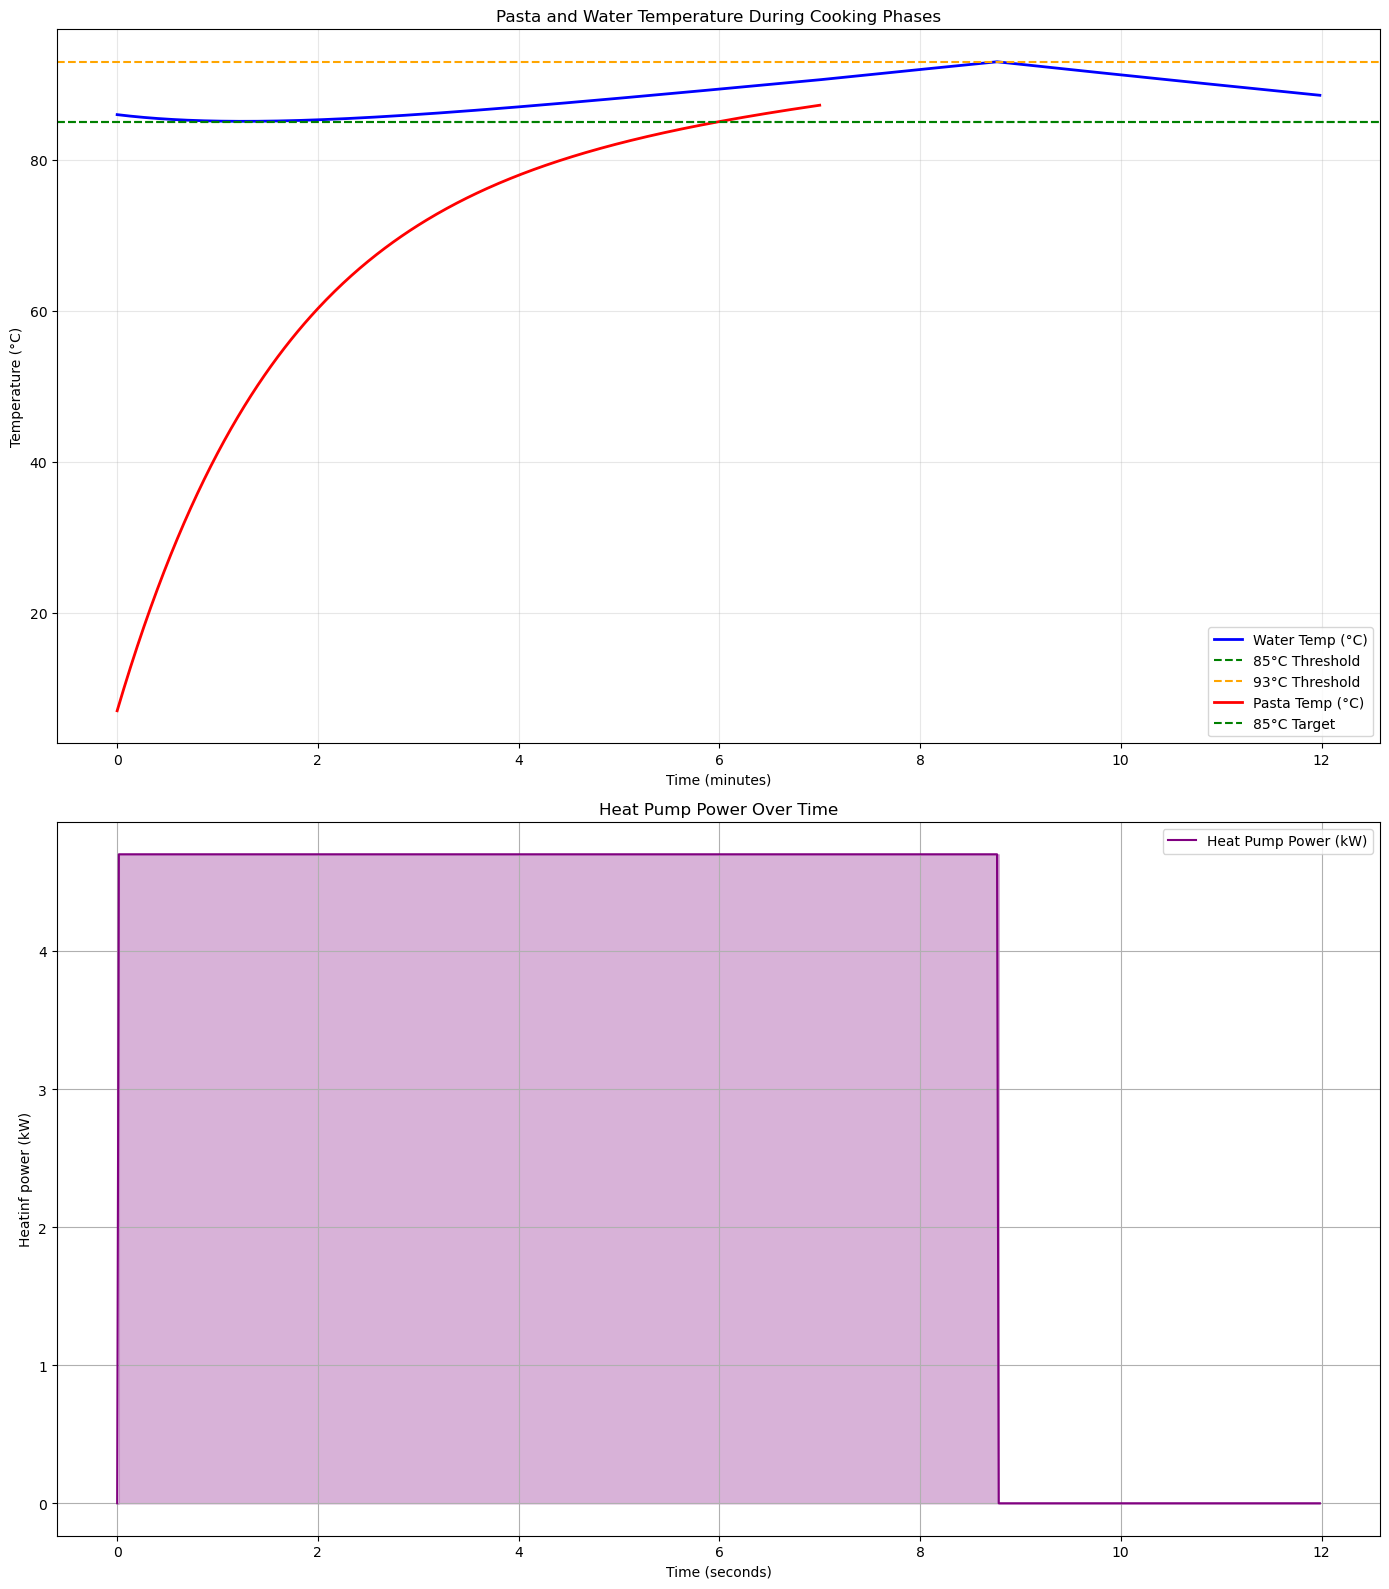


Heater ON during: 8.8 minutes (73.1%)
Total energy consumed: 0.687 kWh
Final pasta temperature: 87.2°C
Final water temperature: 88.6°C

Total energy consumption of the cooker over the 12 hours with a simple on off strategy is : 41.680 kWh


In [12]:
def simple_temp_water_pasta_on_off(T, Q_WP, pasta_in):
    Tw, Tp = T
    Q_pasta = (1/r_water_pasta)*(Tw - Tp) if pasta_in else 0
    dTw = (-1/(mw*cp_water))*(Q_pasta + (1/r_env_water)*(Tw - t_env)) + (1/(mw*cp_water))*Q_WP
    dTp = (1/(r_water_pasta*m_pasta_batch*cp_pasta))*(Tw - Tp) if pasta_in else 0
    return [dTw, dTp]

def  simple_on_off_control_cooking(T_WP_on, T_WP_off, n, op_times):


    dt = 1  # [s] time step

    # Initial values
    T_w = 86
    T_p = 7
    WP_state = 1
    phase = "cooking"
    cook_timer = 0
    pasta_in = 1
    phases = []
    # Results storage
    t_arr = np.zeros(n)
    T = np.zeros((n, 2))
    powers = np.zeros(n)

    T[0, 0] = T_w
    T[0, 1] = T_p
    t_arr[0] = 0
    phases.append(phase)

    for i in range(1, n):
        # Decide phase and pasta_in flag
        if phase == "cooking":
            pasta_in = True
        elif phase == "pause":
            pasta_in = False
            T_p = 0

        # Heat pump on/off control based on water temperature
        if WP_state == 0 and T_w <= T_WP_on:  # Turn ON if temp too low
            WP_state = 1
            Q_WP = P_max / 1000  # Convert W to kW
        elif WP_state == 1 and T_w >= T_WP_off:  # Turn OFF if temp too high
            WP_state = 0
            Q_WP = 0.0
        else:  # Maintain current state
            Q_WP = (P_max / 1000) if WP_state == 1 else 0.0

        powers[i] = Q_WP

        # Always integrate both T_w and T_p, but dTp=0 if pasta_in is False
        z = odeint(lambda T, _: simple_temp_water_pasta_on_off(T, Q_WP, pasta_in), [T_w, T_p], [0, dt])
        T_w, T_p = z[-1]
        if phase == "pause":
            T_p = np.nan

        # Store results
        t_arr[i] = i * dt
        T[i, 0] = T_w
        T[i, 1] = T_p
        phases.append(phase)
        # Phase switching logic
        if phase == "cooking":
            cook_timer += dt
            if cook_timer >= t_cook:
                phase = "pause"
                T_p = np.nan
        elif phase == "pause":
            T_p = np.nan

    # --- Plots: Water temp, Pasta temp, Heat pump power, COP ---
    plt.figure(figsize=(14, 16))

    # Water temperature plot
    plt.subplot(2, 1, 1)
    plt.plot(t_arr/60, T[:, 0], label="Water Temp (°C)", color='b', linewidth=2)
    plt.axhline(85, color='g', linestyle='--', label='85°C Threshold')
    plt.axhline(93, color='orange', linestyle='--', label='93°C Threshold')
    plt.xlabel("Time (seconds)")
    plt.ylabel("Water Temp (°C)")
    plt.title("Water Temperature Over 12 minutes cycle")
    plt.legend()
    plt.grid(True)


    pasta_mask = np.array([p == "cooking" for p in phases[:len(T)]])
    if np.any(pasta_mask):
        plt.plot(t_arr[pasta_mask]/60, T[pasta_mask, 1], label="Pasta Temp (°C)", color='r', linewidth=2)
    plt.axhline(85, color='g', linestyle='--', label='85°C Target')
    plt.xlabel("Time (minutes)")
    plt.ylabel("Temperature (°C)")
    plt.title("Pasta and Water Temperature During Cooking Phases")
    plt.legend()
    plt.grid(True, alpha=0.3)

    #  power plot
    plt.subplot(2, 1, 2)
    plt.plot(t_arr/60, powers, label="Heat Pump Power (kW)", color='purple')
    plt.fill_between(t_arr/60, 0, powers, step='post', alpha=0.3, color='purple')
    plt.xlabel("Time (seconds)")
    plt.ylabel("Heatinf power (kW)")
    plt.title("Heat Pump Power Over Time")
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

    # Calculate statistics for heater ON time
    heating_on = powers > 0  # Boolean array where heater is ON
    heater_on_time = np.sum(heating_on) * dt / 60  # minutes
    total_time = n * dt / 60  # total time in minutes
    efficiency = (heater_on_time / total_time) * 100  # percentage

    # Total energy consumption
    total_power_consumption = np.sum(powers) * dt / 3600  # kWh

    # Get final temperatures
    final_pasta_temp = T[int(t_cook/dt), 1]  # Pasta temp at end of cooking (7 minutes)
    final_water_temp = T[-1, 0]  # Final water temperature

    # Print the statistics you want
    print(f"\nHeater ON during: {heater_on_time:.1f} minutes ({efficiency:.1f}%)")
    print(f"Total energy consumed: {total_power_consumption:.3f} kWh")
    print(f"Final pasta temperature: {final_pasta_temp:.1f}°C")
    print(f"Final water temperature: {final_water_temp:.1f}°C")


    return t_arr, powers, T, total_power_consumption

op_times=[]
t_arr, Q_WPs, T, total_power_consumption = simple_on_off_control_cooking(t_w_min, t_w_max, 12*60, op_times)
# calculate the total energy consumption of the cooker
Total_energy_conv_simple = heating_results_conv['energy_kwh']+total_power_consumption*((12*60-heating_results_conv['time_minutes'])//12)
print(f"\nTotal energy consumption of the cooker over the 12 hours with a simple on off strategy is : {Total_energy_conv_simple:.3f} kWh")


## Task.2 Heat Pump System Design and Optimization

Heat Pump Thermodynamic Cycle
### Coefficient of Performance
$$COP = \frac{\dot{Q}{cond}}{\dot{W}{comp}} = \frac{h_2 - h_3}{h_2 - h_1}$$

Thermodynamic States
State 1 (Evaporator Outlet - Superheated Vapor): $$T_1 = T_{ev} + \Delta T_{sh}, \quad p_1 = p_{sat}(T_{ev})$$

State 2 (Compressor Outlet - High Pressure Vapor): $$h_2 = h_1 + \frac{h_{2s} - h_1}{\eta_{is}}, \quad p_2 = p_{cond}$$

State 3 (Condenser Outlet - Subcooled Liquid): $$T_3 = T_{co} - \Delta T_{sc}, \quad p_3 = p_{sat}(T_{co})$$

State 4 (Expansion Valve Outlet - Two-Phase Mixture): $$h_4 = h_3, \quad p_4 = p_{ev}$$

### Heat Exchanger Design Constraints
Pinch Point Analysis
Evaporator Pinch Points: $$\Delta T_{in,ev} = T_{source} - T_4 \geq \Delta T_{pinch,min} = 0.5K$$

$$\Delta T_{out,ev} = T_{source} - T_1 \geq \Delta T_{pinch,min} = 0.5K$$

Condenser Pinch Points: $$\Delta T_{in,co} = T_2 - T_{sink,out} \geq \Delta T_{pinch,min}$$

$$\Delta T_{out,co} = T_3 - T_{sink,in} \geq \Delta T_{pinch,min}$$

$$\Delta T_{dew,co} = T_{co} - T_{sink,inside} \geq \Delta T_{pinch,min}$$

### Condenser Sizing Calculations
Heat Duties: $$\dot{Q}{VL} = \dot{m} \cdot (h{2,sat} - h_3) \quad \text{(condensation)}$$

$$\dot{Q}V = \dot{m} \cdot (h_2 - h{2,sat}) \quad \text{(desuperheating)}$$

Required Lengths: $$L_{VL} = \frac{\dot{Q}{VL} \cdot 1000 \cdot R{L,VL}}{T_{co} - T_{sink,in}}$$

$$L_V = \frac{\dot{Q}V \cdot 1000 \cdot R{L,sh}}{\Delta T_{ln}}$$

Logarithmic Mean Temperature Difference: $$\Delta T_{ln} = \frac{\Delta T_{in} - \Delta T_{out}}{\ln(\Delta T_{in}/\Delta T_{out})}$$

Total Condenser Constraint: $$L_{cond} = L_{VL} + L_V \leq L_{cond,max}$$

### Thermal Resistance Calculations
Convective Resistance per Unit Length: $$R_{L,conv} = \frac{1}{h \cdot \pi \cdot d} \quad [m \cdot K/W]$$

Conductive Resistance per Unit Length: $$R_{L,cond} = \frac{\delta_w}{\lambda_w \cdot \frac{d_o - d_i}{\ln(d_o/d_i)} \cdot \pi} \quad [m \cdot K/W]$$

Total Thermal Resistances: $$R_{L,sh} = R_{L,h_{ref,VV}} + R_{L,\lambda_w} + R_{L,h_{water}} \quad \text{(superheating)}$$

$$R_{L,VL} = R_{L,h_{ref,VL}} + R_{L,\lambda_w} + R_{L,h_{water}} \quad \text{(condensation)}$$

### Heat Pump Optimization Problem
Objective Function: $$\text{minimize: } \frac{1}{COP} = \frac{h_2 - h_1}{h_2 - h_3}$$

Design Variables: $$\mathbf{x} = [T_{co}, T_{ev}]$$

Bounds: $$T_{sink,in} \leq T_{co} \leq 120°C$$ $$-15°C \leq T_{ev} \leq T_{source}$$

Constraints:

Pinch point constraints (evaporator and condenser)
Capacity constraint: $\dot{Q}{HP} \geq \dot{Q}{required}$
Size constraint: $L_{cond} \leq L_{cond,max}$

In [15]:
#refrigerant
delta_T_sh=10. #K #superheating #determined by us
delta_T_sc=5. #K #subcooling #determined by us
fluid="R1234yf"
Eh="CBar"

#source
fluid_so="air"
T_so_in=20. #°C
T_so_out=20. #°C
T_so = 20.

#sink
fluid_si="water"
T_si_in=85. #°C
T_si_out=85. #°C

#heat exchanger
min_pinch=0.5 #K

In [16]:
def calculate_max_condenser_length(pipe_diameter=6.35, length_available=466, height_available=48, width_available=266):
    """
    Calculate maximum condenser length and heat transfer area for two pipe configurations in the available space. 
    
    Args:
        pipe_diameter: pipe diameter [mm]
        length_available: available length dimension [mm]
        height_available: available height dimension [mm] 
        width_available: available width dimension [mm]
    
    Returns:
        dict: Contains max length, heat transfer area, and configuration details
    """
    
    # Configuration 1: pipes along length direction
    number_of_pipes_1 = (length_available // pipe_diameter)
    L_cond_max_1 = (number_of_pipes_1 * width_available) * (height_available // pipe_diameter) / 1000  # [m]
    
    # Configuration 2: pipes along width direction  
    number_of_pipes_2 = (width_available // pipe_diameter)
    L_cond_max_2 = (number_of_pipes_2 * length_available) * (height_available // pipe_diameter) / 1000  # [m]
    
    # Choose the configuration with maximum length
    L_cond_max = max(L_cond_max_1, L_cond_max_2)
    
    # Calculate maximum heat transfer area
    max_heat_transfer_area = pi * pipe_diameter * L_cond_max / 1000  # [m²]
    
    # Determine optimal configuration
    if L_cond_max_1 > L_cond_max_2:
        optimal_config = 1
        optimal_pipes = number_of_pipes_1
    else:
        optimal_config = 2
        optimal_pipes = number_of_pipes_2
    
    # Print results
    print(f"Max Lcond config 1 with {number_of_pipes_1:.0f} pipes and a total Length of {L_cond_max_1:.2f} m")
    print(f"Max Lcond config 2 with {number_of_pipes_2:.0f} pipes and a total Length of {L_cond_max_2:.2f} m")
    print(f"Max L cond is {L_cond_max:.2f} m (Configuration {optimal_config})")
    print(f"Max heat transfer area is {max_heat_transfer_area:.2f} m²")
    
    return  L_cond_max

L_cond_max = calculate_max_condenser_length()


Max Lcond config 1 with 73 pipes and a total Length of 135.93 m
Max Lcond config 2 with 41 pipes and a total Length of 133.74 m
Max L cond is 135.93 m (Configuration 1)
Max heat transfer area is 2.71 m²


In [17]:
def calc_COP(param, fluid, D):
    """
    Calculate the reciprocal of the Coefficient of Performance (1/COP) for heat pump optimization.
    
    This function models a complete heat pump cycle with the following states:
    - State 1: Evaporator outlet (superheated vapor)
    - State 2: Compressor outlet (high pressure, high temperature vapor)  
    - State 3: Condenser outlet (subcooled liquid)
    - State 4: Throttle valve outlet (low pressure liquid-vapor mixture)
    
    Args:
        param: [T_co, T_ev] - Condensation and evaporation temperatures [°C]
        fluid: Refrigerant fluid name (e.g., "Isobutane", "R1234yf")
        D: Compressor displacement parameter [mm]
    
    Returns:
        float: 1/COP (reciprocal of COP for minimization in optimization)
    """
    
    # Extract operating temperatures from parameter array
    T_co, T_ev = param  # T_co = condensation temp, T_ev = evaporation temp
    
    # Get compressor efficiency and mass flow rate from compressor model
    eta_is, _ = recip_comp_SP([T_ev, T_co, delta_T_sh, delta_T_sc, D], fluid, transcrit=False)
    
    # === STATE 1: EVAPORATOR OUTLET ===
    # State 1*: Saturated vapor at evaporation temperature (reference state)
    state1_sat = FCP.state(["T","x"], [T_ev, 1.0], fluid, Eh)
    
    # State 1: Actual evaporator outlet with superheating
    # If superheating is applied, refrigerant exits at T_ev + delta_T_sh
    if delta_T_sh > 0.:
        # Superheated vapor: same pressure as saturated state, higher temperature
        state1 = FCP.state(["T","p"], [T_ev + delta_T_sh, state1_sat["p"]], fluid, Eh)
    else:
        # No superheating: use saturated vapor state
        state1 = state1_sat

    # === STATE 3: CONDENSER OUTLET ===
    # State 3*: Saturated liquid at condensation temperature (reference state)
    state3_sat = FCP.state(["T","x"], [T_co, 0.0], fluid, Eh)
    
    # State 3: Actual condenser outlet with subcooling
    # Subcooled liquid exits at T_co - delta_T_sc for better cycle efficiency
    state3 = FCP.state(["T","p"], [T_co - delta_T_sc, state3_sat["p"]], fluid, Eh)
    
    # === STATE 2: COMPRESSOR OUTLET ===
    # State 2s: Isentropic compression (ideal case)
    # Same pressure as condenser, same entropy as evaporator outlet
    state2s = FCP.state(["p","s"], [state3["p"], state1["s"]], fluid, Eh)
    
    # State 2: Real compression with efficiency losses
    # Actual enthalpy is higher than isentropic due to inefficiencies
    h2 = state1["h"] + (state2s["h"] - state1["h"]) / eta_is
    
    # Get actual state 2 properties from pressure and enthalpy
    state2 = FCP.state(["p","h"], [state3["p"], h2], fluid, Eh)

    # === STATE 4: THROTTLE VALVE OUTLET ===
    # Isenthalpic expansion (constant enthalpy process)
    # Pressure drops to evaporator level, enthalpy remains same as state 3
    state4 = FCP.state(["p","h"], [state1["p"], state3["h"]], fluid, Eh)

    # === ENERGY CALCULATIONS ===
    # Specific heat released in condenser (useful heating output)
    q_high = state2["h"] - state3["h"]  # [kJ/kg]
    
    # Specific compressor work input (electrical energy required)
    w_comp = state2["h"] - state1["h"]  # [kJ/kg]
    
    # Coefficient of Performance (heating COP)
    COP = q_high / w_comp
    
    # Return reciprocal for optimization (minimize 1/COP = maximize COP)
    return 1.0 / COP

In [18]:
def pinch_evap(param, fluid, D):
    """
    Calculate pinch point temperature differences in the evaporator for heat pump optimization constraints.
    
    This function ensures that the evaporator heat exchanger maintains minimum temperature differences
    to guarantee feasible heat transfer between the refrigerant and air source (20°C).
    
    The evaporator operates in counterflow with:
    - Air (heat source) at constant 20°C
    - Refrigerant: enters as liquid-vapor mixture (state 4), exits as superheated vapor (state 1)
    
    Args:
        param: [T_co, T_ev] - Condensation and evaporation temperatures [°C]
        fluid: Refrigerant fluid name (e.g., "Isobutane", "R1234yf") 
        D: Compressor displacement parameter [mm]
    
    Returns:
        list: [delta_T_in_ev, delta_T_out_ev] - Temperature differences at evaporator inlet and outlet [K]
            These must be ≥ min_pinch (0.5K) for feasible heat transfer
    """
    # Extract operating temperatures from parameter array
    T_co, T_ev = param  # T_co = condensation temp, T_ev = evaporation temp
    
    # Get compressor performance data (efficiency and mass flow rate)
    eta_is, m_dot = recip_comp_SP([T_ev, T_co, delta_T_sh, delta_T_sc, D], fluid, transcrit=False)
    
    # === CALCULATE ALL THERMODYNAMIC STATES FOR COMPLETE CYCLE ===
    
    # STATE 1*: Saturated vapor at evaporation temperature (reference state)
    state1_sat = FCP.state(["T","x"], [T_ev, 1.0], fluid, Eh)
    
    # STATE 1: Actual evaporator outlet with superheating
    if delta_T_sh > 0.:
        state1 = FCP.state(["T","p"], [T_ev + delta_T_sh, state1_sat["p"]], fluid, Eh)
    else:
        # No superheating: use saturated vapor state
        state1 = state1_sat
    
    # STATE 3*: Saturated liquid at condensation temperature (reference state)  
    state3_sat = FCP.state(["T","x"], [T_co, 0.0], fluid, Eh)
    
    # STATE 3: Actual condenser outlet with subcooling
    state3 = FCP.state(["T","p"], [T_co - delta_T_sc, state3_sat["p"]], fluid, Eh)
    
    # STATE 2s: Isentropic compression (ideal reference for efficiency calculation)
    state2s = FCP.state(["p","s"], [state3["p"], state1["s"]], fluid, Eh)
    
    # STATE 2: Real compressor outlet accounting for efficiency losses
    h2 = state1["h"] + (state2s["h"] - state1["h"]) / eta_is
    state2 = FCP.state(["p","h"], [state3["p"], h2], fluid, Eh)
    
    # STATE 4: Throttle valve outlet (evaporator inlet)
    state4 = FCP.state(["p","h"], [state1["p"], state3["h"]], fluid, Eh)
    
    # === EVAPORATOR PINCH POINT ANALYSIS ===
    # The evaporator transfers heat from air (T_so = 20°C) to refrigerant
    # Critical: ensure sufficient temperature difference for heat transfer at both ends
    
    # EVAPORATOR OUTLET pinch point
    # Temperature difference between air source and refrigerant leaving evaporator
    # Air temperature = T_so = 20°C (constant)
    # Refrigerant temperature = state1["T"] (superheated vapor)
    delta_T_out_ev = T_so - state1["T"]
    
    # EVAPORATOR INLET pinch point  
    # Temperature difference between air source and refrigerant entering evaporator
    # Air temperature = T_so = 20°C (constant)
    # Refrigerant temperature = state4["T"] (liquid-vapor mixture after expansion)
    delta_T_in_ev = T_so - state4["T"]
    
    # Return both pinch point temperature differences
    # Optimization constraint: both values must be ≥ min_pinch (0.5K)
    return [delta_T_in_ev, delta_T_out_ev]

In [19]:
def pinch_con(param, fluid, D):
    """
    Calculate pinch point temperature differences in the condenser for heat pump optimization constraints.
    
    This function ensures that the condenser heat exchanger maintains minimum temperature differences
    to guarantee feasible heat transfer between the refrigerant and water sink (85°C).
    
    The condenser operates in counterflow with:
    - Water (heat sink) at 85°C (both inlet and outlet in your case)
    - Refrigerant: enters as superheated vapor (state 2), exits as subcooled liquid (state 3)
    
    The condenser process involves three distinct phases:
    1. Desuperheating: superheated vapor → saturated vapor
    2. Condensation: saturated vapor → saturated liquid (isothermal)
    3. Subcooling: saturated liquid → subcooled liquid
    
    Args:
        param: [T_co, T_ev] - Condensation and evaporation temperatures [°C]
        fluid: Refrigerant fluid name (e.g., "Isobutane", "R1234yf")
        D: Compressor displacement parameter [mm]
    
    Returns:
        list: [delta_T_in_co, delta_T_out_co, delta_T_inside_co] - Temperature differences [K]
            All must be ≥ min_pinch (0.5K) for feasible heat transfer
    """
    
    # Extract operating temperatures from parameter array
    T_co, T_ev = param  # T_co = condensation temp, T_ev = evaporation temp
    
    # Get compressor performance data (efficiency and mass flow rate)
    eta_is, m_dot = recip_comp_SP([T_ev, T_co, delta_T_sh, delta_T_sc, D], fluid, transcrit=False)
    
    # === CALCULATE ALL THERMODYNAMIC STATES FOR COMPLETE CYCLE ===
    
    # STATE 1*: Saturated vapor at evaporation temperature (reference state)
    state1_sat = FCP.state(["T","x"], [T_ev, 1.0], fluid, Eh)
    
    # STATE 1: Actual evaporator outlet with superheating
    if delta_T_sh > 0.:
        state1 = FCP.state(["T","p"], [T_ev + delta_T_sh, state1_sat["p"]], fluid, Eh)
    else:
        state1 = state1_sat
    
    # STATE 3*: Saturated liquid at condensation temperature (reference state)
    state3_sat = FCP.state(["T","x"], [T_co, 0.0], fluid, Eh)
    
    # STATE 3: Actual condenser outlet with subcooling
    state3 = FCP.state(["T","p"], [T_co - delta_T_sc, state3_sat["p"]], fluid, Eh)
    
    # STATE 2s: Isentropic compression (ideal reference for efficiency calculation)
    state2s = FCP.state(["p","s"], [state3["p"], state1["s"]], fluid, Eh)
    
    # STATE 2: Real compressor outlet accounting for efficiency losses
    h2 = state1["h"] + (state2s["h"] - state1["h"]) / eta_is
    state2 = FCP.state(["p","h"], [state3["p"], h2], fluid, Eh)
    
    # === CONDENSER PINCH POINT ANALYSIS ===

    # CONDENSER OUTLET pinch point
    # Temperature difference between refrigerant leaving condenser and water entering
    # In counterflow: refrigerant outlet (state 3) meets water inlet (T_si_in)
    delta_T_out_co = state3["T"] - T_si_in
    
    # CONDENSER INLET pinch point
    # Temperature difference between refrigerant entering condenser and water leaving
    # In counterflow: refrigerant inlet (state 2) meets water outlet (T_si_out)
    delta_T_in_co = state2["T"] - T_si_out
    
    # === DEW LINE CONDENSER PINCH POINT ===
    # where refrigerant transitions from vapor to liquid
    # This requires detailed energy balance to find water temperature at dew point
    
    # Enthalpy values for energy balance
    h_out_co = state3["h"]  # Refrigerant outlet enthalpy [kJ/kg]
    h_in_co = state2["h"]   # Refrigerant inlet enthalpy [kJ/kg]
    
    # Enthalpy of saturated vapor at condensation conditions (dew point)
    h_sat_Tco = FCP.state(["T","x"], [T_co, 1.0], fluid, Eh)["h"]
    
    # Water enthalpies at inlet and outlet conditions
    h_si_in = FCP.state(["T","p"], [T_si_in, 1.0], fluid_si, Eh)["h"]
    h_si_out = FCP.state(["T","p"], [T_si_out, 1.0], fluid_si, Eh)["h"]
    
    # Energy balance to find water temperature when refrigerant reaches dew line
    # Heat released by refrigerant from inlet to dew point = Heat absorbed by water
    # (h_in_co - h_sat_Tco) * m_ref = (h_si_inside - h_si_out) * m_water
    # Since m_ref = m_water (approximately), we can solve for h_si_inside
    h_si_inside = h_si_out - (h_si_out - h_si_in) / (state2["h"] - state3["h"]) * (state2["h"] - h_sat_Tco)
    
    # Convert water enthalpy to temperature at dew line location
    T_si_inside = FCP.state(["p","h"], [1.0, h_si_inside], fluid_si, Eh)["T"]
    
    # DEW LINE temperature difference
    # Most restrictive constraint: condensation temperature vs water temperature at dew line
    delta_T_inside_co = T_co - T_si_inside
    
    # Return all three pinch point temperature differences
    # Optimization constraint: all values must be ≥ min_pinch (0.5K)
    return [delta_T_in_co, delta_T_out_co, delta_T_inside_co]

In [20]:
# Calculate required heating capacity from Task 1
Q_required =  P_max / 1000 # [kW]

#Define appropriate bounds
bounds=[(T_si_in,120.),(-15.,T_so)] #(T_co_min, T_co_max), (T_ev_min, T_ev_max)

# Add condenser size constraint
lambda_steel=25. #W/mK
h_ref_liquid = 1000 #W/m^2/K
h_ref_vapor_liquid = 2000   #W/m^2/K
h_ref_vapor_vapor = 200 #W/m^2/K
h_water = 1000 #W/m^2/K

# === calculation of the thermal resistances ===
#thermal resistance times tube length for convective heat transfer
def calc_RL_conv(h,d):
    R_L_conv=1./(h*pi*d) #[m.K/W]
    return R_L_conv

#thermal resistance times tube length for conductive heat transfer
def calc_RL_cond(lambda_w,d_w,d_out,d_i):
    R_L_cond= d_w/(lambda_w*((d_out-d_i)/(log(d_out/d_i)))*pi) #[m.K/W]
    return R_L_cond

#convective heat transfer inner tube wall when Refrigirent is vapor
R_L_h_refVV=calc_RL_conv(h_ref_vapor_vapor,d_i)
#convective heat transfer inner tube wall when Refrigirent is vapor-liquid
R_L_h_refVL=calc_RL_conv(h_ref_vapor_liquid,d_i)
#conductive heat transfer through wall
R_L_lambda_w=calc_RL_cond(lambda_steel,d_w,d_o,d_i)
#convective heat transfer outer tube wall
R_L_h_water=calc_RL_conv(h_water,d_o)

# Total resistance during SUPERHEATING (vapor only)
R_L_sh=R_L_h_refVV+R_L_lambda_w+R_L_h_water #m.K/W
print("thermal resistance per meter during vapor part =",round(R_L_sh,4),"mK/W")
# Total resistance during CONDENSATION (vapor-liquid mixture)
R_L_VL=R_L_h_refVL+R_L_lambda_w+R_L_h_water #m.K/W
print("thermal resistance per meter during Vapor Liquid part =",round(R_L_VL,4),"mK/W")

thermal resistance per meter during vapor part = 0.0388 mK/W
thermal resistance per meter during Vapor Liquid part = 0.0086 mK/W


In [21]:
# For each optimized heat pump design, check:
def check_capacity_condenser_constraint(T_co, T_ev, fluid, D, Q_required, R_L_VL, R_L_sh):
    """
    Check if heat pump design meets capacity requirements and condenser size constraints.
    
    This function validates that an optimized heat pump configuration can:
    1. Provide sufficient heating capacity (≥ Q_required)
    2. Fit within available condenser space (≤ L_cond_max)
    
    The condenser is divided into two sections:
    - Desuperheating section: vapor refrigerant cools to saturation temperature
    - Condensation section: two-phase refrigerant condenses to liquid
    
    Args:
        T_co: condensation temperature [°C]
        T_ev: evaporation temperature [°C] 
        fluid: refrigerant fluid name
        D: compressor displacement [mm]
        Q_required: minimum required heating capacity [kW]
        R_L_VL: thermal resistance per length during condensation [m·K/W]
        R_L_sh: thermal resistance per length during superheating [m·K/W]
    
    Returns:
        tuple: (feasible_bool, Q_hp, L_cond)
            - feasible_bool: True if both capacity and size constraints are met
            - Q_hp: actual heat pump capacity [kW]
            - L_cond: total required condenser length [m]
    """
    
    # === CALCULATE HEAT PUMP PERFORMANCE ===
    # Get compressor efficiency and refrigerant mass flow rate
    eta_is, m_dot = recip_comp_SP([T_ev, T_co, delta_T_sh, delta_T_sc, D], fluid, transcrit=False)
    
    # === CALCULATE ALL THERMODYNAMIC STATES ===
    
    # STATE 1*: Saturated vapor at evaporation temperature
    state1_sat = FCP.state(["T","x"], [T_ev, 1.0], fluid, Eh)
    
    # STATE 1: Actual evaporator outlet (with superheating if applied)
    if delta_T_sh > 0:
        state1 = FCP.state(["T","p"], [T_ev + delta_T_sh, state1_sat["p"]], fluid, Eh)
    else:
        state1 = state1_sat
    
    # STATE 3*: Saturated liquid at condensation temperature
    state3_sat = FCP.state(["T","x"], [T_co, 0.0], fluid, Eh)
    
    # STATE 3: Actual condenser outlet (with subcooling)
    state3 = FCP.state(["T","p"], [T_co - delta_T_sc, state3_sat["p"]], fluid, Eh)
    
    # STATE 2s: Isentropic compression (ideal case)
    state2s = FCP.state(["p","s"], [state3["p"], state1["s"]], fluid, Eh)
    
    # STATE 2: Real compressor outlet (accounting for efficiency)
    h2 = state1["h"] + (state2s["h"] - state1["h"]) / eta_is
    state2 = FCP.state(["p","h"], [state3["p"], h2], fluid, Eh)
    
    # STATE 2*: Saturated vapor at condensation pressure (dew point)
    state2_sat = FCP.state(["p","x"], [state3["p"], 1.0], fluid, Eh)

    # === CALCULATE HEAT PUMP CAPACITY ===
    # Specific heat released in condenser [kJ/kg]
    q_cond = state2["h"] - state3["h"]
    
    # Total heat pump capacity [kW]
    Q_hp = m_dot * q_cond

    # === CALCULATE HEAT DUTIES FOR EACH CONDENSER SECTION ===
    
    # Heat released during CONDENSATION (two-phase region)
    # From saturated vapor to saturated liquid
    Q_VL = m_dot * (state2_sat["h"] - state3["h"])  # [kW]
    
    # Heat released during DESUPERHEATING (vapor cooling)
    # From superheated vapor to saturated vapor  
    Q_V = m_dot * (state2["h"] - state2_sat["h"])   # [kW]

    # === CALCULATE REQUIRED CONDENSER LENGTHS ===
    
    # Length for CONDENSATION section
    L_VL = Q_VL * 1000.0 * R_L_VL / (T_co - T_si_in)  # [m]

    # Length for DESUPERHEATING section
    # Calculate logarithmic mean temperature difference for varying temperatures
    
    # Temperature differences at inlet and outlet of desuperheating section
    T_in_desuper = state2["T"]     # Hot refrigerant vapor enters
    T_out_desuper = T_co          # Cooled to saturation temperature
    
    # Temperature differences with water (counterflow arrangement)
    delta_T_in = T_in_desuper - T_si_out   # Hot end: vapor vs water outlet
    delta_T_out = T_out_desuper - T_si_in  # Cool end: saturated vapor vs water inlet
    
    # Logarithmic mean temperature difference (LMTD)
    if delta_T_in != delta_T_out:
        delta_T_ln = (delta_T_in - delta_T_out) / np.log(delta_T_in / delta_T_out)
    else:
        # If temperature differences are equal, LMTD = constant difference
        delta_T_ln = delta_T_in

    # Length for desuperheating section using LMTD
    L_V = Q_V * 1000.0 * R_L_sh / delta_T_ln  # [m]
    
    # === TOTAL CONDENSER LENGTH ===
    L_cond = L_VL + L_V  # [m]
    
    # === CHECK FEASIBILITY CONSTRAINTS ===
    
    # Constraint 1: Heat pump capacity must meet minimum requirement
    capacity_ok = (Q_hp >= Q_required)
    
    # Constraint 2: Condenser must fit within available space
    size_ok = (L_cond <= L_cond_max)
    
    # Overall feasibility: both constraints must be satisfied
    feasible = capacity_ok and size_ok
    
    return feasible, Q_hp, L_cond

In [22]:
#Define an appropriate initial guess (starting point).
T_co_start=40. #°C
T_ev_start=-5. #°C

results = []
feasible_designs = []
fluids = ["Isobutane","Butane","Isobutene","DimethylEther"]  
for fluid in fluids:
    T_crit = CP.PropsSI("Tcrit", fluid)
    print(f"{fluid}: Critical Temperature = {T_crit:.2f} K")
Ds = [35, 40, 45, 50]  
for fluid in fluids:
    for D in Ds: 
        def calc_COP_opt(x):
            return calc_COP(x, fluid, D)
        def pinch_evap_opt(x):
            return pinch_evap(x, fluid, D)
        def pinch_con_opt(x):
            return pinch_con(x, fluid, D)
        NC1=NonlinearConstraint(pinch_evap_opt, [min_pinch,min_pinch],[np.inf,np.inf])
        NC2=NonlinearConstraint(pinch_con_opt, [min_pinch,min_pinch,min_pinch],[np.inf,np.inf,np.inf])
        #All constraints can be combined into a tuple
        NCs=(NC1,NC2)
        #Use minimize to optimize the COP
        res=minimize(calc_COP_opt,x0=[T_co_start,T_ev_start],method='SLSQP',bounds=bounds,constraints=NCs)
        T_co = res.x[0]
        T_ev = res.x[1]

        state1_sat=FCP.state(["T","x"],[T_ev,1.0],fluid,Eh)
        #state1_op: outlet evaporator: T1=T_ev_op+delta_T_sh and p1=p1_sat
        if delta_T_sh>0.:
            state1=FCP.state(["T","p"],[T_ev+delta_T_sh,state1_sat["p"]],fluid,Eh)
        else:
            state1=state1_sat

        #state3_sat_op: outlet condenser: T3=T_co_op and x3=0.0 (boiling liquid)
        state3_sat=FCP.state(["T","x"],[T_co,0.0],fluid,Eh)
        #state3_op: outlet condenser: T3=T_co_op-delta_T_sc and p3=p3_stat
        state3=FCP.state(["T","p"],[T_co-delta_T_sc,state3_sat["p"]],fluid,Eh)

        #state2s_op: isentropic compressor: p2s=p_co=p3 and s2s=s1 
        state2s=FCP.state(["p","s"],[state3["p"],state1["s"]],fluid,Eh)
        #enthalpy h2 is calulated using the compressor efficiency eta_is
        eta_is, m_dot = recip_comp_SP([T_ev, T_co, delta_T_sh, delta_T_sc, D], fluid, transcrit=False) 
        h2=state1["h"]+(state2s["h"]-state1["h"])/eta_is
        #state2_op: outlet compressor: p2=p_co=p3 and h2
        state2=FCP.state(["p","h"],[state3["p"],h2],fluid,Eh)
        
        T_crit = CP.PropsSI("Tcrit", fluid)
        if state2["T"] > (T_crit - 273.15):
            break

        results.append({
            "fluid": fluid,
            "D": D,
            "success": res.success,
            "T_co": res.x[0],
            "T_ev": res.x[1],
            "COP": 1. / calc_COP_opt(res.x), 
            "fun": res.fun, # 1/COP
            "flux": m_dot, # kg/s
            "superheating": delta_T_sh,
            "subcooling": delta_T_sc
        })

for result in results:
    if result['success']:
        can_meet_demand, Q_hp, L_cond = check_capacity_condenser_constraint(result['T_co'], result['T_ev'], result['fluid'], result['D'], Q_required, R_L_VL, R_L_sh)
        if can_meet_demand:
            result['Q_hp'] = Q_hp
            result['L_cond'] = L_cond
            feasible_designs.append(result)

print(f"Feasible designs: {len(feasible_designs)} out of {len(results)}")
# Convert results to DataFrame for easy analysis
opti = pd.DataFrame(feasible_designs)
#print(opti)

# Optionally, print the best result
best = opti.loc[opti['COP'].idxmax()]
print("\nBest optimization result:")
print(f"Fluid: {best['fluid']}, D: {best['D']}")
print(f"Optimized COP = {best['COP']:.2f}")
print(f"Optimized condensation temperature = {best['T_co']:.2f} °C")
print(f"Optimized evaporation temperature = {best['T_ev']:.2f} °C")
print(f"Heat pump capacity = {best['Q_hp']:.2f} kW")
print(f"Condenser length = {best['L_cond']:.2f} m")
Q_hp = best['Q_hp']


Isobutane: Critical Temperature = 407.82 K
Butane: Critical Temperature = 425.12 K
Isobutene: Critical Temperature = 418.09 K
DimethylEther: Critical Temperature = 400.38 K
Feasible designs: 8 out of 12

Best optimization result:
Fluid: Isobutene, D: 40
Optimized COP = 2.35
Optimized condensation temperature = 90.50 °C
Optimized evaporation temperature = 9.50 °C
Heat pump capacity = 4.91 kW
Condenser length = 8.51 m


### Heat pump process visualization

In [25]:
fluid=best['fluid']
D=best['D']
T_ev_op=best['T_ev'] #°C
T_co_op=best['T_co'] #°C
eta_is=recip_comp_SP([T_ev_op,T_co_op,delta_T_sh,delta_T_sc,D],fluid,transcrit=False)[0]

#evaporator
delta_T_pinch_ev=pinch_evap([T_co_op,T_ev_op],fluid,D)
print("Pinch evaporator (optimized): delta_T_pinch_v=",round(min(delta_T_pinch_ev[0],delta_T_pinch_ev[1]),4),"K")
#condenser
delta_T_pinch_co=pinch_con([T_co_op,T_ev_op],fluid,D)
print("Pinch condenser (optimized): delta_T_pinch_c=",round(min(delta_T_pinch_co[0],delta_T_pinch_co[1],delta_T_pinch_co[2]),4),"K")

state1_sat_op=FCP.state(["T","x"],[T_ev_op,1.0],fluid,Eh)
#state1_op: outlet evaporator: T1=T_ev_op+delta_T_sh and p1=p1_sat
if delta_T_sh>0.:
    state1_op=FCP.state(["T","p"],[T_ev_op+delta_T_sh,state1_sat_op["p"]],fluid,Eh)
else:
    state1_op=state1_sat_op

#state3_sat_op: outlet condenser: T3=T_co_op and x3=0.0 (boiling liquid)
state3_sat_op=FCP.state(["T","x"],[T_co_op,0.0],fluid,Eh)
#state3_op: outlet condenser: T3=T_co_op-delta_T_sc and p3=p3_stat
state3_op=FCP.state(["T","p"],[T_co_op-delta_T_sc,state3_sat_op["p"]],fluid,Eh)

#state2s_op: isentropic compressor: p2s=p_co=p3 and s2s=s1 
state2s_op=FCP.state(["p","s"],[state3_op["p"],state1_op["s"]],fluid,Eh)
#enthalpy h2 is calulated using the compressor efficiency eta_is
h2_op=state1_op["h"]+(state2s_op["h"]-state1_op["h"])/eta_is
#state2_op: outlet compressor: p2=p_co=p3 and h2
state2_op=FCP.state(["p","h"],[state3_op["p"],h2_op],fluid,Eh)
#state4_op: outlet throttle: p4=p_ev=p1 and h4=h3 (isenthalpic throttle)
state4_op=FCP.state(["p","h"],[state1_op["p"],state3_op["h"]],fluid,Eh)

#print(state2_op)

Pinch evaporator (optimized): delta_T_pinch_v= 0.5 K
Pinch condenser (optimized): delta_T_pinch_c= 0.5 K


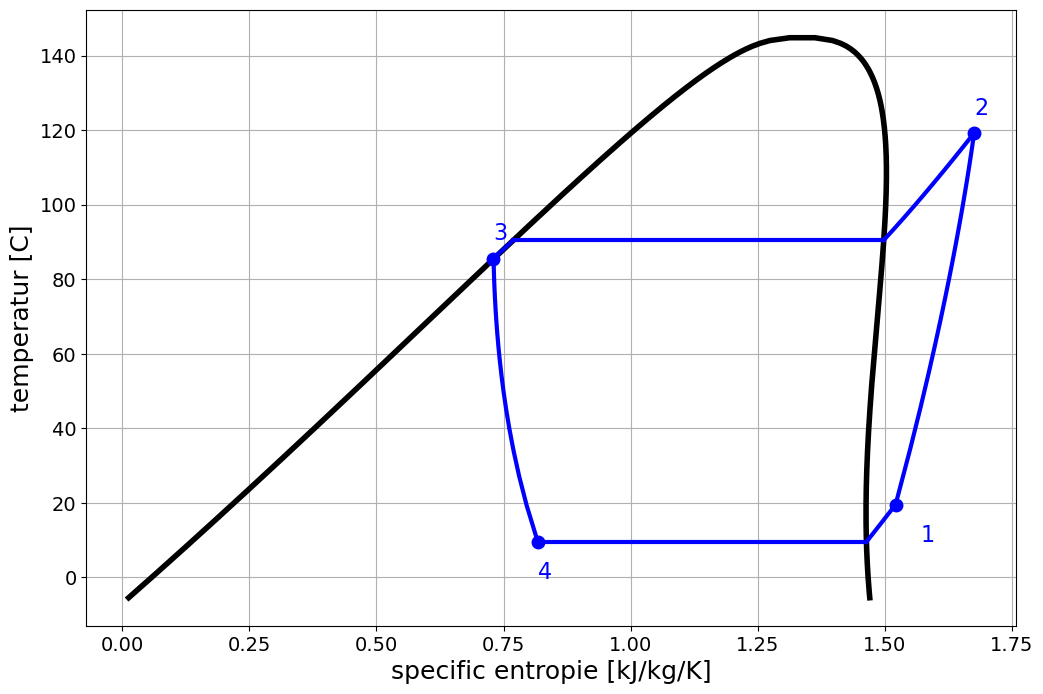

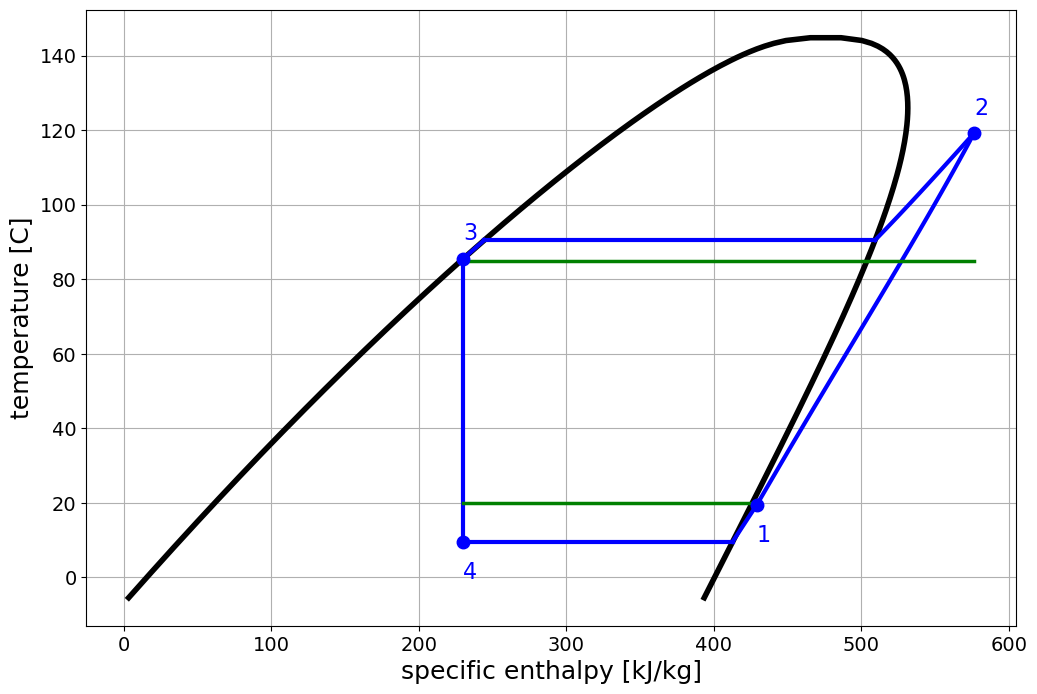

In [26]:
Diag.Ts(state1_op,state2_op,state3_op,state4_op,fluid,Eh)
Diag.Th(state1_op,state2_op,state3_op,state4_op,[T_si_in,T_si_out],[T_so_in,T_so_out],fluid,Eh)

## Task 3: Integrated Heat Pump System Analysis

## Heat Pump Performance Modeling
### Polynomial Performance Curves
$$COP(T_{sink}) = a_0 + a_1 T_{sink} + a_2 T_{sink}^2$$

$$\dot{Q_{HP}}(T{sink}) = b_0 + b_1 T_{sink} + b_2 T_{sink}^2$$

Where coefficients are determined by fitting optimization results across temperature range 80-100°C.

Residual COP Calculation
$$COP_{res} = COP(T_w) \cdot \frac{\frac{P_{rated}}{\dot{Q_{WP}}}}{0.9 \cdot \frac{P{rated}}{\dot{Q_{WP}}} + 0.1}$$

This accounts for part-load efficiency degradation.

### Integrated System Dynamics
Modified Temperature Dynamics: $$\frac{dT_w}{dt} = \frac{1}{m_w \cdot c_{p,w}} \left[ \dot{Q_{HP}}(T_w) \cdot u(t) - \dot{Q_{pasta}} - \dot{Q_{env}} \right]$$

Where $u(t)$ is the heat pump on/off control signal and $\dot{Q_{HP}}(T_w)$ 

Electrical Power Consumption: $$\dot{W}{elec} = \frac{\dot{Q_{HP}}}{COP_{res}(T_w)}$$

Multi-Phase Operation Strategy
Phase Transition Logic: $$\text{Phase} = \begin{cases} \text{Heating} & \text{if } T_w < 86°C \ \text{Cooking} & \text{if } T_w \geq 86°C \text{ and } t_{cook_timer} < 420s \ \text{Pause} & \text{if } t_{cook_timer} \geq 420s \text{ and } t_{pause_timer} < 300s \end{cases}$$

### Performance Evaluation and Scoring

Evaluation Metrics
Heating Time: Time required to reach operating temperature from ambient $$t_{heating} = \arg\min_t {T_w(t) \geq T_{w,min} + 1°C}$$

Total Energy Consumption (12 hours): $$E_{total} = \int_0^{43200} \dot{W}_{elec}(t) , dt \quad [kWh]$$

Multi-Criteria Scoring System
Individual Scores (0-1 scale, higher is better): $$S_{heating} = 1 - \frac{t_{heating}}{t_{heating,max}}$$

$$S_{energy} = 1 - \frac{E_{total}}{E_{total,max}}$$

$$S_{switches} = 1 - \frac{N_{switches}}{N_{switches,max}}$$

Weighted Total Score: $$S_{total} = w_1 S_{heating} + w_2 S_{energy} + w_3 S_{switches}$$

Where: $w_1 = 0.3$ (heating time), $w_2 = 0.6$ (energy), $w_3 = 0.1$ (switches)

#### Design Space Exploration
Refrigerants Evaluated:

Isobutane, Butane, Isobutene, Dimethyl Ether
Compressor Displacements:

D = 35, 40, 45, 50 mm
Feasibility Criteria:

Thermodynamic optimization convergence
Capacity requirement: $\dot{Q_{HP}} \geq \dot{Q}{required}$
Size constraint: $L_{cond} \leq L_{cond,max}$
Critical temperature limit: $T_2 < T_{crit} - 273.15$


In [38]:
def temp_water_pasta_HP(T, t, Q_WP, pasta_in):
    Tw, Tp = T
    Q_pasta = (1/r_water_pasta)*(Tw - Tp) if pasta_in else 0
    dTw = (-1/(mw*cp_water))*(Q_pasta + (1/r_env_water)*(Tw - t_env)) + (1/(mw*cp_water))*Q_WP
    dTp = (1/(r_water_pasta*m_pasta_batch*cp_pasta))*(Tw - Tp) if pasta_in else 0
    return [dTw, dTp]

In [39]:
def simple_on_off_control_HP(T_WP_on, T_WP_off, n, op_times):
    # Declare global variables properly
    global t_w_min, t_w_max, t_p_0, t_w_init, t_cook, t_break, poly_heat, poly_cop, temp_water_pasta_HP, calc_WP, WP, time

    dt = 1  # [s] time step

    # Initialize global variables first
    WP = 0    # Heat pump state
    time = 0  # Operation counter

    # Initial values
    T_w = t_w_init
    T_p = t_p_0
    phase = "heating"
    cook_timer = 0
    pause_timer = 0
    
    # CRITICAL: Initialize Q_WP before first use
    try:
        QHP = float(poly_heat(T_w))
        Q_WP = calc_WP(T_w, T_WP_on, T_WP_off, op_times, QHP)
    except Exception as e:
        print(f"ERROR: Failed to initialize heat pump power: {e}")
        return None, None, None, None, None

    # Results storage
    t_arr = np.zeros(n)
    T = np.zeros((n, 2))
    Q_WPs = np.zeros(n)
    COPs = np.zeros(n)
    COPres = np.zeros(n)
    Power_consumption = np.zeros(n)
    phase_arr = []

    T[0, 0] = T_w
    T[0, 1] = T_p
    t_arr[0] = 0
    Q_WPs[0] = Q_WP  # Store initial Q_WP
    
    try:
        COPs[0] = float(poly_cop(T_w))
    except Exception as e:
        print(f"ERROR: Failed to initialize COP: {e}")
        return None, None, None, None, None

    heating_phase_duration = 0  # [s]

    for i in range(1, n):
        # Decide phase and pasta_in flag
        if phase == "heating":
            pasta_in = False
            T_p = t_p_0
        elif phase == "cooking":
            pasta_in = True
        elif phase == "pause":
            pasta_in = False
            T_p = 0

        # NOW Q_WP is properly initialized - use it in ODE integration
        try:
            z = odeint(lambda T, _: temp_water_pasta_HP(T, 0, Q_WP, pasta_in), [T_w, T_p], [0, dt])
            T_w, T_p = z[-1]
        except Exception as e:
            print(f"ERROR: ODE integration failed at step {i}: {e}")
            break
        
        if phase == "pause":
            pasta_in = False
            T_p = np.nan
            
        # Store results
        t_arr[i] = i * dt
        T[i, 0] = T_w
        T[i, 1] = T_p
        phase_arr.append(phase)
        
        try:
            COPs[i] = float(poly_cop(T_w))
        except Exception as e:
            print(f"ERROR: COP calculation failed at step {i}: {e}")
            COPs[i] = COPs[i-1] if i > 0 else 3.0  # Use previous value or fallback
        
        # Calculate residual COP and power consumption
        if Q_WP > 0:  # Only when heat pump is running
            try:
                COPres[i] = COPs[i] * ((4.7/Q_WP)/(0.9*(4.7/Q_WP) + 0.1))
                Power_consumption[i] = Q_WP / COPres[i]  # Electrical power [kW]
            except (ZeroDivisionError, ValueError) as e:
                COPres[i] = 0
                Power_consumption[i] = 0
        else:
            COPres[i] = 0
            Power_consumption[i] = 0
        
        # Compute new QHP and Q_WP for NEXT step
        try:
            QHP = float(poly_heat(T_w))
            Q_WP = calc_WP(T_w, T_WP_on, T_WP_off, op_times, QHP)
            Q_WPs[i] = Q_WP
        except Exception as e:
            print(f"ERROR: Heat pump power update failed at step {i}: {e}")
            Q_WP = Q_WPs[i-1] if i > 0 else 0  # Use previous value or 0
            Q_WPs[i] = Q_WP

        # Phase switching logic
        if phase == "heating":
            heating_phase_duration += dt
            if T_w >= t_w_min+1:
                phase = "cooking"
                T_p = t_p_0
                cook_timer = 0
        elif phase == "cooking":
            cook_timer += dt
            if cook_timer >= t_cook:
                phase = "pause"
                pause_timer = 0
                T_p = 0
        elif phase == "pause":
            pause_timer += dt
            T_p = np.nan
            if pause_timer >= t_break:
                phase = "cooking"
                T_p = t_p_0
                cook_timer = 0

    # --- Plots: Water temp, Pasta temp, Heat pump power, COP ---
    plt.figure(figsize=(14, 16))

    # Water temperature plot
    plt.subplot(4, 1, 1)
    plt.plot(t_arr, T[:, 0], label="Water Temp (°C)", color='b')
    plt.axhline(85, color='g', linestyle='--', label='85°C Threshold')
    plt.axhline(93, color='orange', linestyle='--', label='93°C Threshold')
    plt.xlabel("Time (seconds)")
    plt.ylabel("Water Temp (°C)")
    plt.title("Water Temperature Over 12 Hours")
    plt.legend()
    plt.grid(True)

    # Pasta temperature plot
    plt.subplot(4, 1, 2)
    plt.plot(t_arr, T[:, 1], label="Pasta Temp (°C)", color='r')
    plt.axhline(85, color='g', linestyle='--', label='85°C Threshold')
    plt.xlabel("Time (seconds)")
    plt.ylabel("Pasta Temp (°C)")
    plt.title("Pasta Temperature Over 12 Hours")
    plt.legend()
    plt.grid(True)

    # Heat pump power plot
    plt.subplot(4, 1, 3)
    plt.plot(t_arr, Q_WPs, label="Heat Pump Power (kW)", color='purple')
    plt.xlabel("Time (seconds)")
    plt.ylabel("Q_WP (kW)")
    plt.title("Heat Pump Power Over Time")
    plt.legend()
    plt.grid(True)

    # COP plot
    plt.subplot(4, 1, 4)
    plt.plot(t_arr, COPres, label="Residual COP", color='teal')
    plt.xlabel("Time (seconds)")
    plt.ylabel("Residual COP")
    plt.title("Heat Pump residual COP Over Time")
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

    # Compute total power consumption in kWh
    total_power_consumption = np.sum(Power_consumption) * dt / 3600  # kWh

    return t_arr, Q_WPs, T, total_power_consumption, heating_phase_duration

In [40]:
def evaluate_all_feasible_designs():
    """
    Evaluate all feasible heat pump designs using simple_on_off_control_HP
    and return results with scoring system.
    """
    global time, WP, op_times1, poly_heat, poly_cop
    
    # Store all results
    all_results = []
    
    print(f"Evaluating {len(feasible_designs)} feasible designs...")
    
    for idx, design in enumerate(feasible_designs):
        fluid = design['fluid']
        D = design['D']
        
        print(f"\nEvaluating Design {idx+1}/{len(feasible_designs)}: {fluid}, D={D}")
        
        # Generate polynomial fits for this specific fluid and D combination
        T_si_range = np.arange(80, 100, 1)  # °C sink temperature range
        COP_list = []
        Heat_cap = []
        
        print(f"  Generating performance data...")
        successful_points = 0
        
        for T_si in T_si_range:
            # Update sink conditions for this temperature
            global T_si_in, T_si_out  # Make sure we update global values
            T_si_in = T_si
            T_si_out = T_si
            
            T_co_start = 40.0  # °C
            T_ev_start = -5.0  # °C
            bounds_local = [(T_si, 120.), (-15., T_so)]
            
            # Define constraint functions for this specific fluid and D
            def pinch_evap_local(x):
                return pinch_evap(x, fluid, D)
            def pinch_con_local(x):
                return pinch_con(x, fluid, D)
            
            NC1 = NonlinearConstraint(pinch_evap_local, [min_pinch, min_pinch], [np.inf, np.inf])
            NC2 = NonlinearConstraint(pinch_con_local, [min_pinch, min_pinch, min_pinch], [np.inf, np.inf, np.inf])
            NCs = (NC1, NC2)
            
            # Optimize COP for this temperature
            try:
                res = minimize(lambda x: calc_COP(x, fluid, D), x0=[T_co_start, T_ev_start], method='SLSQP', bounds=bounds_local, constraints=NCs)
                
                if res.success:
                    T_co = res.x[0]
                    T_ev = res.x[1]
                    
                    # Calculate states and performance
                    eta_is, m_dot = recip_comp_SP([T_ev, T_co, delta_T_sh, delta_T_sc, D], fluid, transcrit=False)
                    state1_x1 = FCP.state(["T", "x"], [T_ev, 1.0], fluid, Eh)
                    
                    if delta_T_sh > 0.:
                        state1 = FCP.state(["T", "p"], [T_ev + delta_T_sh, state1_x1["p"]], fluid, Eh)
                    else:
                        state1 = state1_x1
                    
                    state3_sat = FCP.state(["T", "x"], [T_co, 0.0], fluid, Eh)
                    state3 = FCP.state(["T", "p"], [T_co - delta_T_sc, state3_sat["p"]], fluid, Eh)
                    state2s = FCP.state(["p", "s"], [state3["p"], state1["s"]], fluid, Eh)
                    h2 = state1["h"] + (state2s["h"] - state1["h"]) / eta_is
                    state2 = FCP.state(["p", "h"], [state3["p"], h2], fluid, Eh)
                    
                    q_out = state2["h"] - state3["h"]  # kJ/kg
                    w_comp = state2["h"] - state1["h"]  # kJ/kg
                    
                    COP_list.append(q_out / w_comp)
                    Heat_cap.append(q_out * m_dot)
                    successful_points += 1
                    
            except Exception as e:
                print(f"    Warning: Optimization failed for T_si={T_si}: {e}")
                continue
        
        print(f"  Successfully calculated {successful_points} out of {len(T_si_range)} temperature points")
        
        # Fit polynomial curves with robust handling
        if len(COP_list) >= 3 and len(Heat_cap) >= 3:
            try:
                # Use successful temperature points only
                T_successful = T_si_range[:len(COP_list)]
                
                # Fit with appropriate degree (max 2nd order or data points - 1)
                degree = min(2, len(COP_list) - 1)
                poly_cop = Polynomial.fit(T_successful, COP_list, degree)
                poly_heat = Polynomial.fit(T_successful, Heat_cap, degree)
                
                print(f"  Polynomial fitting successful (degree {degree})")
                
                # Test polynomial at operating temperature to catch overflow
                try:
                    test_cop = float(poly_cop(85.0))
                    test_heat = float(poly_heat(85.0))
                    if not (np.isfinite(test_cop) and np.isfinite(test_heat)):
                        raise ValueError("Polynomial produces non-finite values")
                except Exception as e:
                    print(f"  ERROR: Polynomial test failed: {e}")
                    continue
                    
            except Exception as e:
                print(f"  ERROR: Polynomial fitting failed for {fluid}, D={D}: {e}")
                continue
        else:
            print(f"  ERROR: Insufficient data points ({len(COP_list)}) for {fluid}, D={D}")
            continue
        
        # Reset sink conditions to original values
        T_si_in = 85.0
        T_si_out = 85.0
        
        # Reset global variables for heat pump controller
        time = 0
        WP = 0
        op_times1 = []
        
        print(f"  Running heat pump simulation...")
        
        # Run simple_on_off_control_HP simulation
        try:
            result_sim = simple_on_off_control_HP(
                T_WP_on=85,  # °C
                T_WP_off=93,  # °C
                n=sim_duration,
                op_times=op_times1
            )
            
            # Check if simulation was successful
            if result_sim[0] is None:
                print(f"  ERROR: Heat pump simulation failed for {fluid}, D={D}")
                continue
                
            t1, Q_WPs1, T1, total_consumption, heating_phase_dur = result_sim
            
            # Finalize operating times if HP is still running
            if time != 0:
                op_times1.append(time)
            
            # Calculate metrics
            heating_time_minutes = heating_phase_dur / 60  # minutes
            num_switches = len(op_times1)
            total_energy_kwh = total_consumption
            
            # Store results
            result = {
                'fluid': fluid,
                'D': D,
                'COP': design['COP'],
                'Q_hp': design['Q_hp'],
                'L_cond': design['L_cond'],
                'heating_time_minutes': heating_time_minutes,
                'total_energy_kwh': total_energy_kwh,
                'num_switches': num_switches,
                'op_times': op_times1.copy(),
                'design_index': idx
            }
            
            all_results.append(result)
            
            print(f"  SUCCESS - Heating time: {heating_time_minutes:.1f} min, Energy: {total_energy_kwh:.3f} kWh, Switches: {num_switches}")
            
        except Exception as e:
            print(f"  ERROR: Heat pump simulation failed for {fluid}, D={D}: {e}")
            continue
    
    return all_results

Starting  heat pump design evaluation...
Evaluating 8 feasible designs...

Evaluating Design 1/8: Isobutane, D=40
  Generating performance data...
  Successfully calculated 20 out of 20 temperature points
  Polynomial fitting successful (degree 2)
  Running heat pump simulation...


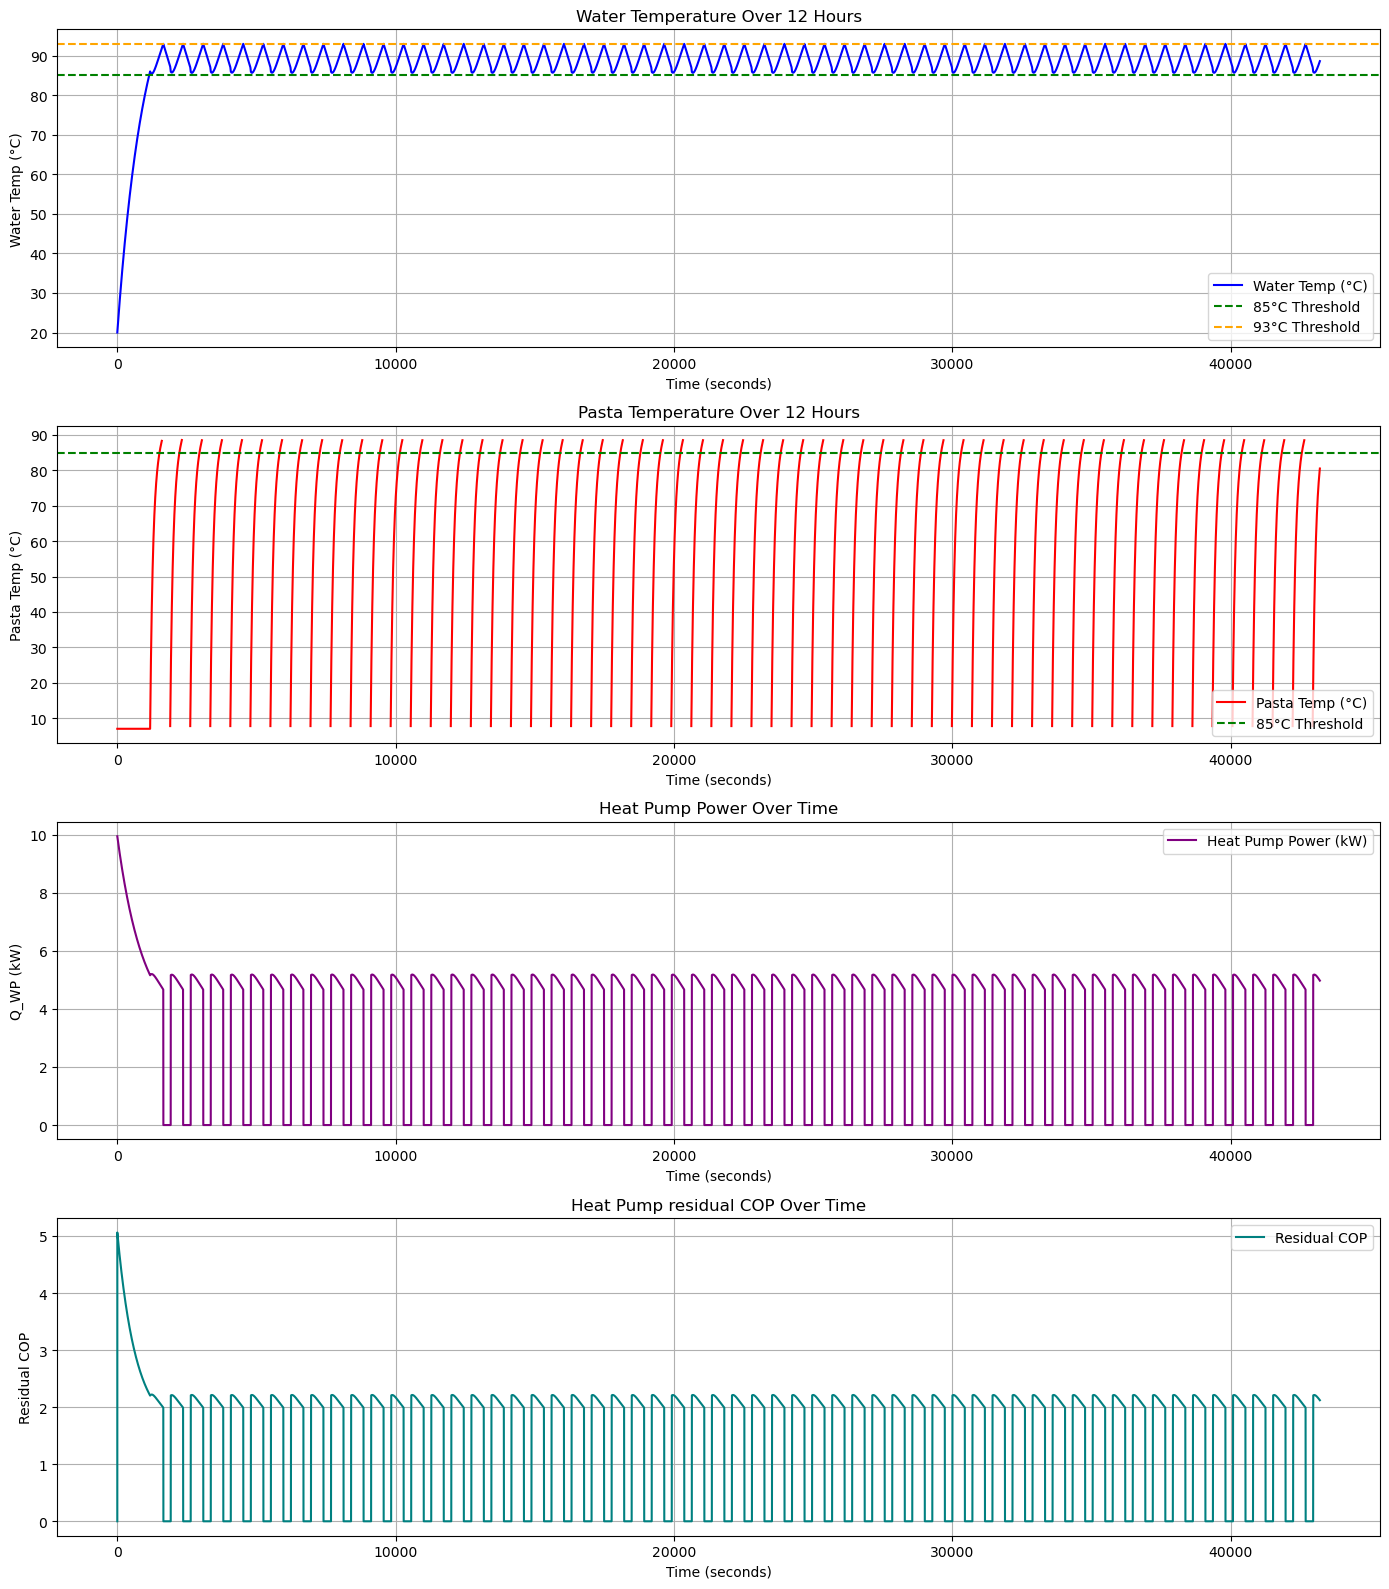

  SUCCESS - Heating time: 19.6 min, Energy: 17.790 kWh, Switches: 59

Evaluating Design 2/8: Isobutane, D=45
  Generating performance data...
  Successfully calculated 20 out of 20 temperature points
  Polynomial fitting successful (degree 2)
  Running heat pump simulation...


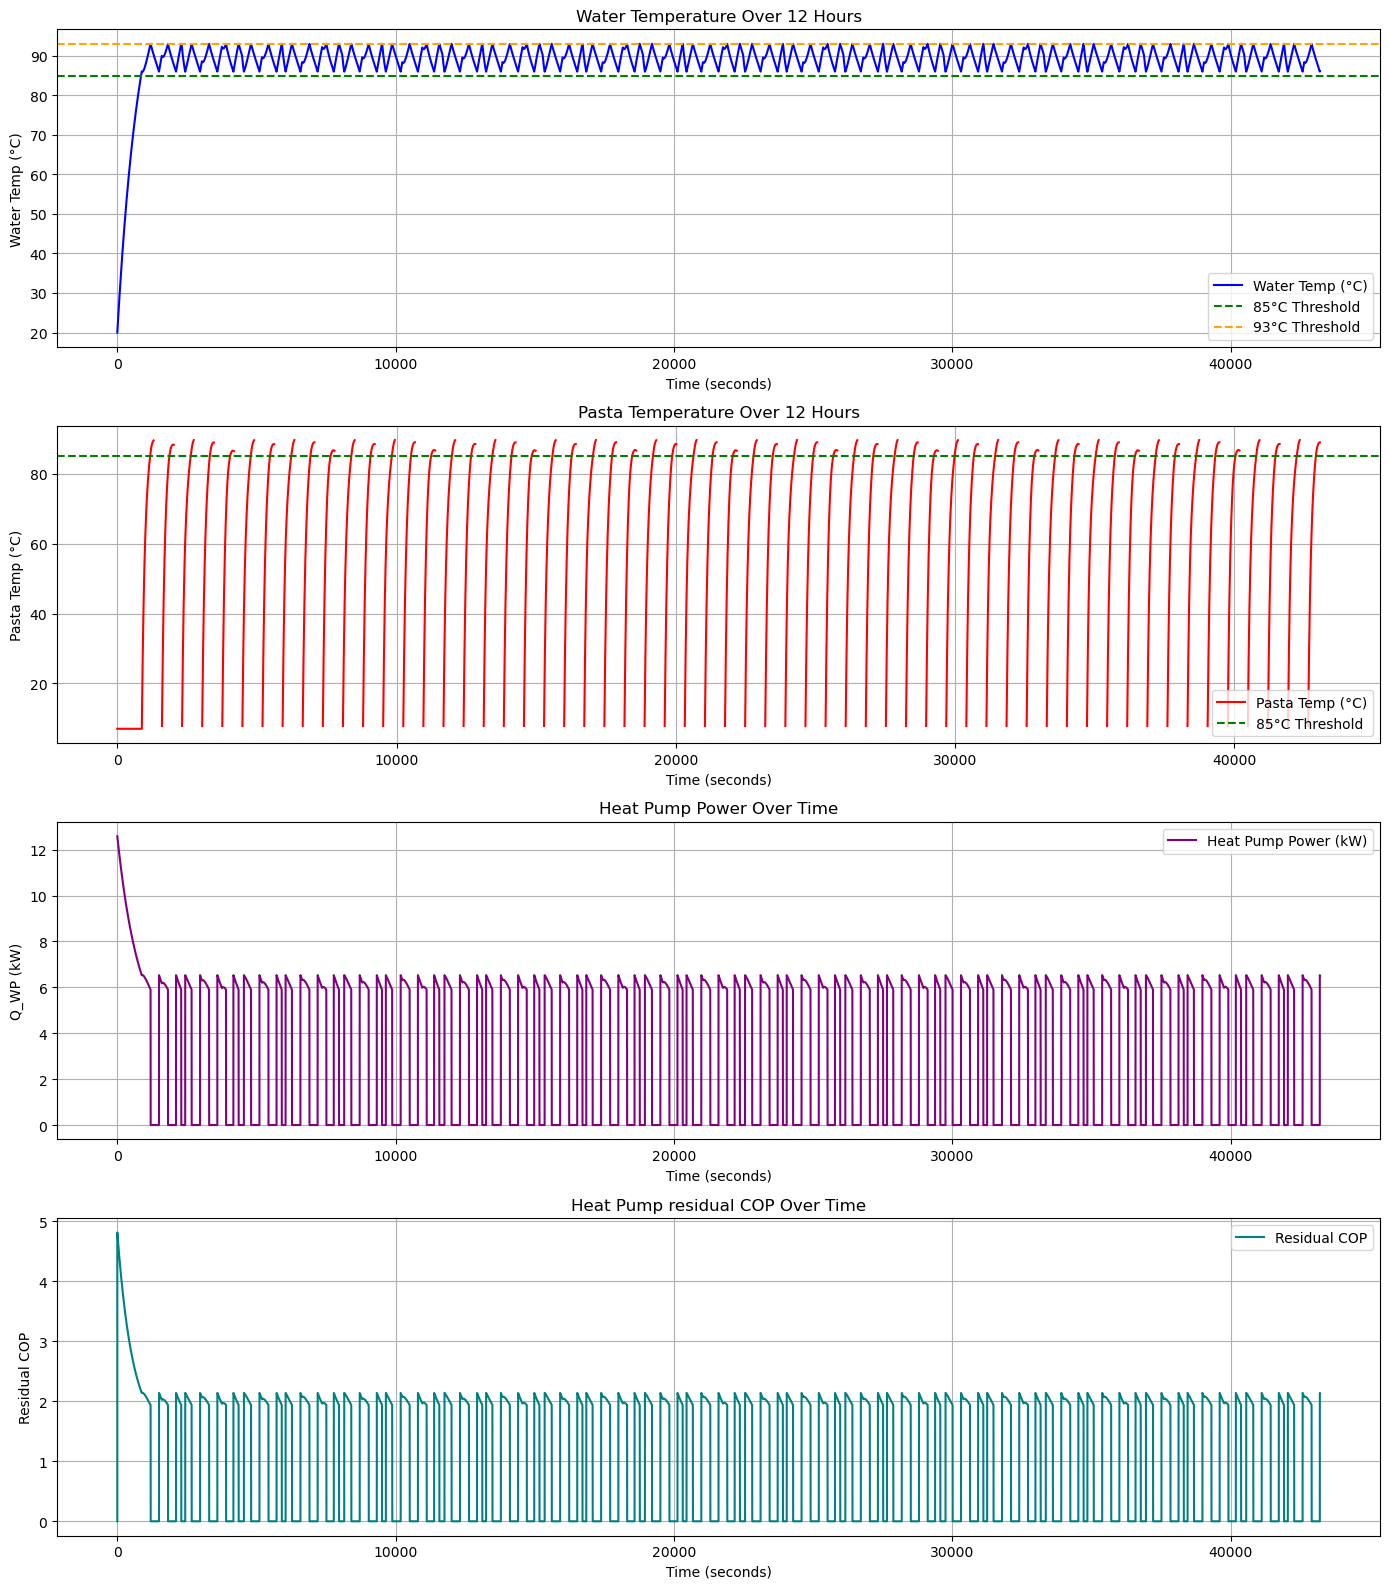

  SUCCESS - Heating time: 14.6 min, Energy: 18.722 kWh, Switches: 83

Evaluating Design 3/8: Isobutane, D=50
  Generating performance data...
  Successfully calculated 20 out of 20 temperature points
  Polynomial fitting successful (degree 2)
  Running heat pump simulation...


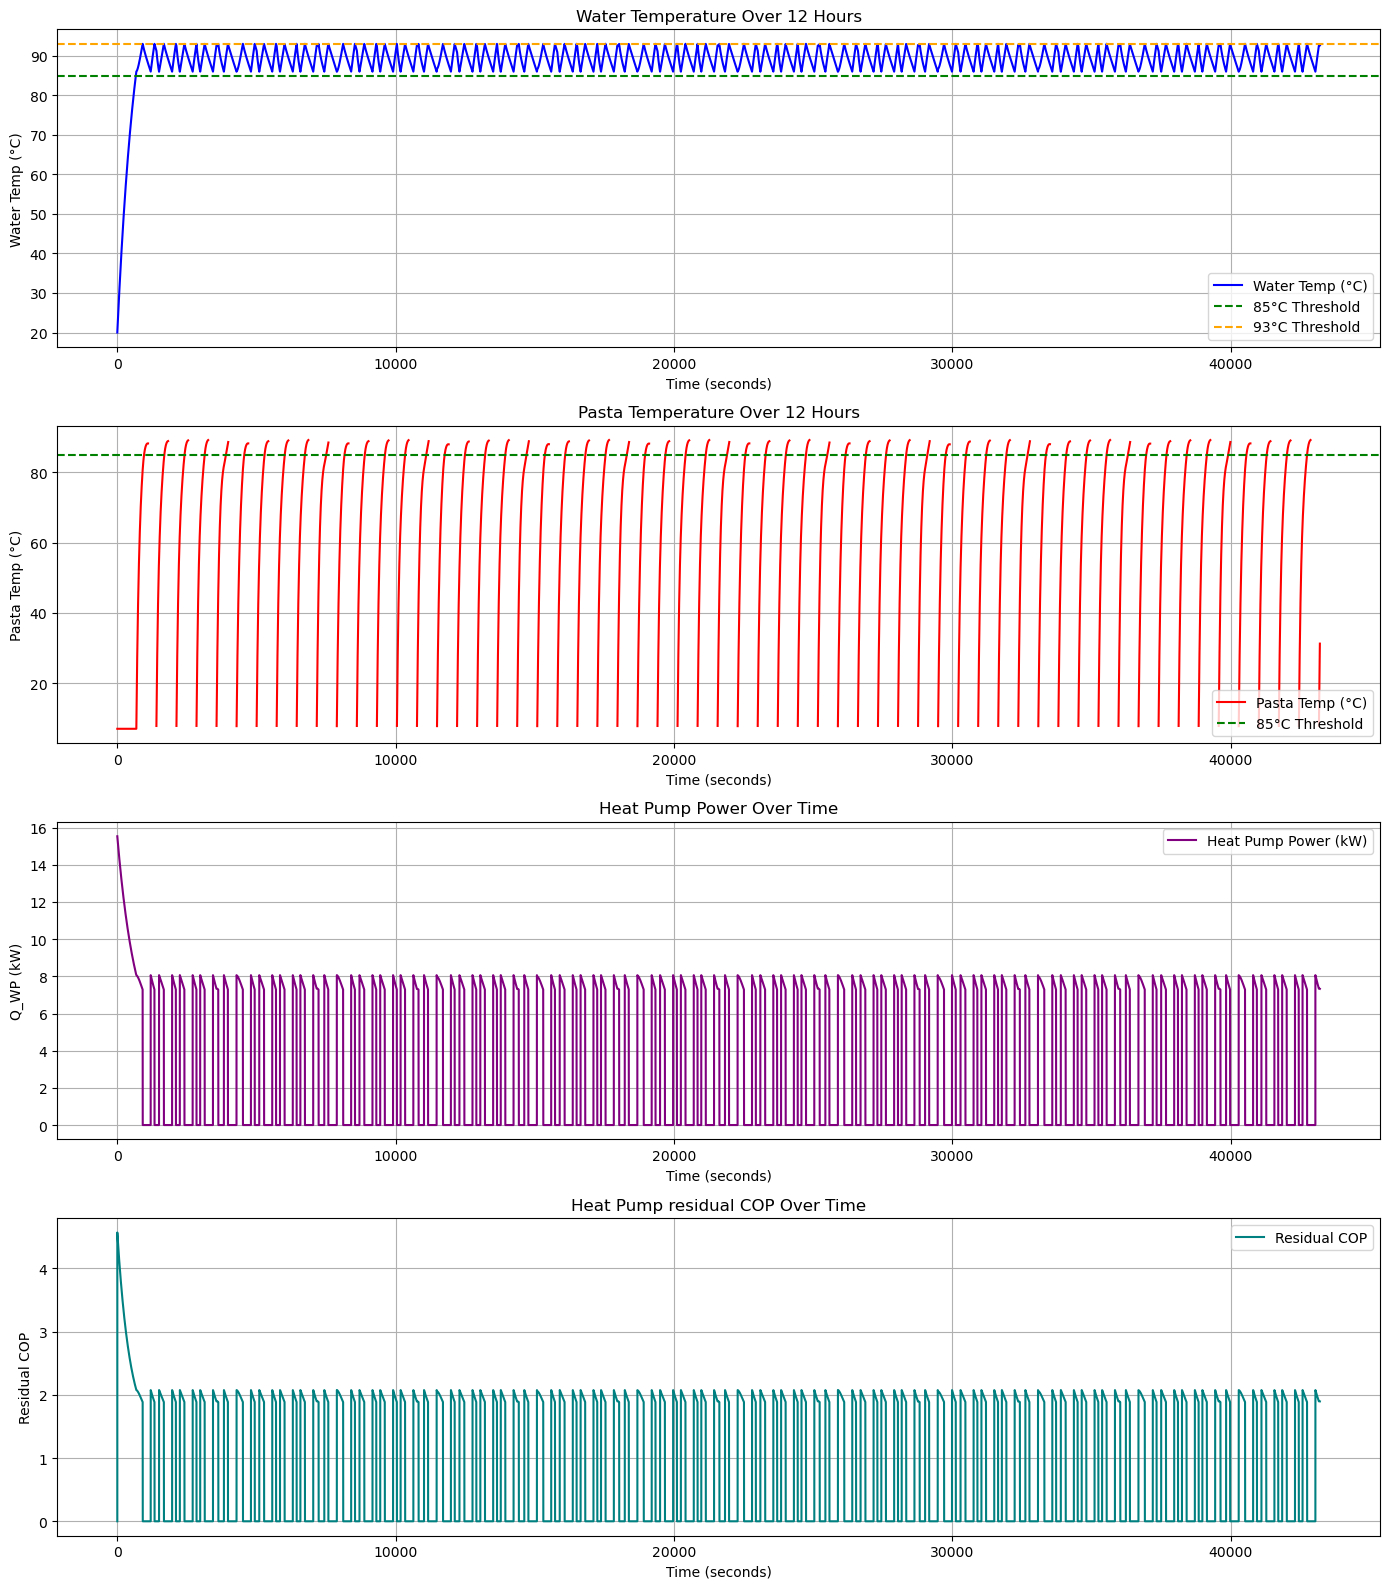

  SUCCESS - Heating time: 11.4 min, Energy: 19.404 kWh, Switches: 107

Evaluating Design 4/8: Butane, D=45
  Generating performance data...


In [ ]:
def calculate_scores_and_find_best(all_results):
    """
    Calculate scores for each design and find the best one.
    Weights: heating_time=0.4, energy=0.5, switches=0.1
    """
    if not all_results:
        print("No results to evaluate!")
        return None
    
    # Extract metrics for normalization
    heating_times = [r['heating_time_minutes'] for r in all_results]
    energies = [r['total_energy_kwh'] for r in all_results]
    switches = [r['num_switches'] for r in all_results]
    
    # Find max values for normalization (lower is better, so we use max to normalize)
    max_heating_time = max(heating_times)
    max_energy = max(energies)
    max_switches = max(switches)
    
    # Calculate scores (1 = best, 0 = worst)
    weights = {'heating_time': 0.3, 'energy': 0.6, 'switches': 0.1}
    
    for result in all_results:
        # Score calculation (inverted because lower values are better)
        heating_score = 1 - (result['heating_time_minutes'] / max_heating_time)
        energy_score = 1 - (result['total_energy_kwh'] / max_energy)
        switches_score = 1 - (result['num_switches'] / max_switches)
        
        # Weighted total score
        total_score = (weights['heating_time'] * heating_score + 
                      weights['energy'] * energy_score + 
                      weights['switches'] * switches_score)
        
        # Store individual scores
        result['heating_score'] = heating_score
        result['energy_score'] = energy_score
        result['switches_score'] = switches_score
        result['total_score'] = total_score
    
    # Sort by total score (highest first)
    all_results.sort(key=lambda x: x['total_score'], reverse=True)
    
    # Print results
    print("\n" + "="*80)
    print("HEAT PUMP DESIGN EVALUATION RESULTS")
    print("="*80)
    print(f"{'Rank':<4} {'Fluid':<12} {'D':<4} {'Heat.Time':<10} {'Energy':<10} {'Switches':<9} {'Total Score':<12}")
    print("-"*80)
    
    for i, result in enumerate(all_results):
        print(f"{i+1:<4} {result['fluid']:<12} {result['D']:<4} "
            f"{result['heating_time_minutes']:<10.1f} {result['total_energy_kwh']:<10.3f} "
            f"{result['num_switches']:<9} {result['total_score']:<12.3f}")
    
    # Best design details
    best = all_results[0]
    print("\n" + "="*60)
    print("BEST HEAT PUMP DESIGN")
    print("="*60)
    print(f"Fluid: {best['fluid']}")
    print(f"Compressor Displacement (D): {best['D']} mm")
    print(f"COP: {best['COP']:.2f}")
    print(f"Heat Pump Capacity: {best['Q_hp']:.2f} kW")
    print(f"Condenser Length: {best['L_cond']:.2f} m")
    print(f"\nPerformance Metrics:")
    print(f"  Heating Time: {best['heating_time_minutes']:.1f} minutes")
    print(f"  Total Energy Consumption: {best['total_energy_kwh']:.3f} kWh")
    print(f"  Number of On/Off Switches: {best['num_switches']}")
    print(f"\nScores (0-1, higher is better):")
    print(f"  Heating Time Score: {best['heating_score']:.3f} (weight: {weights['heating_time']})")
    print(f"  Energy Score: {best['energy_score']:.3f} (weight: {weights['energy']})")
    print(f"  Switches Score: {best['switches_score']:.3f} (weight: {weights['switches']})")
    print(f"  Total Weighted Score: {best['total_score']:.3f}")
    
    return all_results

# Run the evaluation
print("Starting  heat pump design evaluation...")
all_design_results = evaluate_all_feasible_designs()
final_results = calculate_scores_and_find_best(all_design_results)

best_total_energy_hp = final_results[0]['total_energy_kwh'] if final_results else None


# Task 4

In [ ]:
def compare_heating_systems(Co2, price, Total_energy_conv_opt, Total_energy_conv_simple, best_total_energy_hp):
    """
    Compare conventional heating systems vs heat pump in terms of cost and CO2 emissions.
    
    Args:
        Co2: CO2 emission factor [kg CO2-eq/kWh]
        price: Electricity price [CHF/kWh]
        Total_energy_conv_opt: Total energy consumption with optimized conventional strategy [kWh]
        Total_energy_conv_simple: Total energy consumption with simple conventional strategy [kWh]
        best_total_energy_hp: Total energy consumption with best heat pump design [kWh]
    
    Returns:
        dict: Comparison results with costs, emissions, and savings
    """
    
    # Calculate costs for each system
    cost_conv_opt = Total_energy_conv_opt * price
    cost_conv_simple = Total_energy_conv_simple * price
    cost_hp = best_total_energy_hp * price
    
    # Calculate CO2 emissions for each system
    co2_conv_opt = Total_energy_conv_opt * Co2
    co2_conv_simple = Total_energy_conv_simple * Co2
    co2_hp = best_total_energy_hp * Co2
    
    # Calculate savings compared to conventional systems
    # vs Optimized Conventional
    cost_savings_vs_opt = cost_conv_opt - cost_hp
    cost_savings_pct_vs_opt = (cost_savings_vs_opt / cost_conv_opt) * 100
    co2_savings_vs_opt = co2_conv_opt - co2_hp
    co2_savings_pct_vs_opt = (co2_savings_vs_opt / co2_conv_opt) * 100
    
    # vs Simple Conventional
    cost_savings_vs_simple = cost_conv_simple - cost_hp
    cost_savings_pct_vs_simple = (cost_savings_vs_simple / cost_conv_simple) * 100
    co2_savings_vs_simple = co2_conv_simple - co2_hp
    co2_savings_pct_vs_simple = (co2_savings_vs_simple / co2_conv_simple) * 100
    
    # Create results dictionary
    results = {
        'energy_consumption': {
            'conv_optimized': Total_energy_conv_opt,
            'conv_simple': Total_energy_conv_simple,
            'heat_pump': best_total_energy_hp
        },
        'costs': {
            'conv_optimized': cost_conv_opt,
            'conv_simple': cost_conv_simple,
            'heat_pump': cost_hp
        },
        'co2_emissions': {
            'conv_optimized': co2_conv_opt,
            'conv_simple': co2_conv_simple,
            'heat_pump': co2_hp
        },
        'savings_vs_optimized': {
            'cost_savings': cost_savings_vs_opt,
            'cost_savings_percent': cost_savings_pct_vs_opt,
            'co2_savings': co2_savings_vs_opt,
            'co2_savings_percent': co2_savings_pct_vs_opt
        },
        'savings_vs_simple': {
            'cost_savings': cost_savings_vs_simple,
            'cost_savings_percent': cost_savings_pct_vs_simple,
            'co2_savings': co2_savings_vs_simple,
            'co2_savings_percent': co2_savings_pct_vs_simple
        }
    }
    
    # Print detailed comparison
    print("="*80)
    print("HEATING SYSTEM COMPARISON - 12 HOUR OPERATION")
    print("="*80)
    
    print(f"\n{'System':<25} {'Energy [kWh]':<12} {'Cost [CHF]':<12} {'CO2 [kg]':<12}")
    print("-"*65)
    print(f"{'Conventional (Optimized)':<25} {Total_energy_conv_opt:<12.3f} {cost_conv_opt:<12.3f} {co2_conv_opt:<12.3f}")
    print(f"{'Conventional (Simple)':<25} {Total_energy_conv_simple:<12.3f} {cost_conv_simple:<12.3f} {co2_conv_simple:<12.3f}")
    print(f"{'Heat Pump (Best)':<25} {best_total_energy_hp:<12.3f} {cost_hp:<12.3f} {co2_hp:<12.3f}")
    
    print("\n" + "="*80)
    print("HEAT PUMP SAVINGS ANALYSIS")
    print("="*80)
    
    print(f"\nVs Optimized Conventional System:")
    print(f"  Energy Reduction: {Total_energy_conv_opt - best_total_energy_hp:.3f} kWh ({(Total_energy_conv_opt - best_total_energy_hp)/Total_energy_conv_opt*100:.1f}%)")
    print(f"  Cost Savings: {cost_savings_vs_opt:.3f} CHF ({cost_savings_pct_vs_opt:.1f}%)")
    print(f"  CO2 Reduction: {co2_savings_vs_opt:.3f} kg ({co2_savings_pct_vs_opt:.1f}%)")
    
    print(f"\nVs Simple Conventional System:")
    print(f"  Energy Reduction: {Total_energy_conv_simple - best_total_energy_hp:.3f} kWh ({(Total_energy_conv_simple - best_total_energy_hp)/Total_energy_conv_simple*100:.1f}%)")
    print(f"  Cost Savings: {cost_savings_vs_simple:.3f} CHF ({cost_savings_pct_vs_simple:.1f}%)")
    print(f"  CO2 Reduction: {co2_savings_vs_simple:.3f} kg ({co2_savings_pct_vs_simple:.1f}%)")
    
    # Annual projections
    print(f"\n" + "="*80)
    print("ANNUAL PROJECTIONS (assuming 365 days of operation)")
    print("="*80)
    
    annual_factor = 365 * 2  # 365 days, 2 operations per day (12h each)
    
    print(f"\nAnnual Energy Consumption:")
    print(f"  Conventional (Optimized): {Total_energy_conv_opt * annual_factor:.1f} kWh/year")
    print(f"  Conventional (Simple): {Total_energy_conv_simple * annual_factor:.1f} kWh/year")
    print(f"  Heat Pump (Best): {best_total_energy_hp * annual_factor:.1f} kWh/year")
    
    print(f"\nAnnual Cost:")
    print(f"  Conventional (Optimized): {cost_conv_opt * annual_factor:.2f} CHF/year")
    print(f"  Conventional (Simple): {cost_conv_simple * annual_factor:.2f} CHF/year")
    print(f"  Heat Pump (Best): {cost_hp * annual_factor:.2f} CHF/year")
    
    print(f"\nAnnual CO2 Emissions:")
    print(f"  Conventional (Optimized): {co2_conv_opt * annual_factor:.1f} kg CO2-eq/year")
    print(f"  Conventional (Simple): {co2_conv_simple * annual_factor:.1f} kg CO2-eq/year")
    print(f"  Heat Pump (Best): {co2_hp * annual_factor:.1f} kg CO2-eq/year")
    
    print(f"\nAnnual Savings with Heat Pump:")
    print(f"  vs Optimized: {cost_savings_vs_opt * annual_factor:.2f} CHF/year, {co2_savings_vs_opt * annual_factor:.1f} kg CO2-eq/year")
    print(f"  vs Simple: {cost_savings_vs_simple * annual_factor:.2f} CHF/year, {co2_savings_vs_simple * annual_factor:.1f} kg CO2-eq/year")
    
    return results

# Example usage:
comparison_results = compare_heating_systems(
    Co2=Co2,
    price=price, 
    Total_energy_conv_opt=Total_energy_conv_opt,
    Total_energy_conv_simple=Total_energy_conv_simple,
    best_total_energy_hp=best_total_energy_hp
)